In [ ]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval
from collections import Counter
from collections import defaultdict


import matplotlib.pyplot as plt
import seaborn as sns


from langdetect import detect

from pymorphy2 import MorphAnalyzer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

import fasttext
import fasttext.util

from sentence_transformers import SentenceTransformer

import hdbscan


from scipy.stats import normaltest


In [924]:
# Загружаем данные 

df = pd.read_csv('full_data_stage_1.csv')

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18692 entries, 0 to 18691
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          18692 non-null  object 
 1   date              18692 non-null  object 
 2   vacancy           18692 non-null  object 
 3   company           18692 non-null  object 
 4   city              18692 non-null  object 
 5   experience        17398 non-null  object 
 6   employment        18692 non-null  object 
 7   schedule          18692 non-null  object 
 8   salary from       18692 non-null  float64
 9   salary to         18692 non-null  float64
 10  currency          18692 non-null  object 
 11  skills            11651 non-null  object 
 12  url               18692 non-null  object 
 13  ID                18677 non-null  float64
 14  country           1294 non-null   object 
 15  industry          17383 non-null  object 
 16  text              18672 non-null  object

#### 1. Data Cleaning + Data Preparation

In [132]:
df['skills'].isna().sum()

7041

In [925]:
df = df.dropna(subset=['skills'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11651 entries, 0 to 18691
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          11651 non-null  object 
 1   date              11651 non-null  object 
 2   vacancy           11651 non-null  object 
 3   company           11651 non-null  object 
 4   city              11651 non-null  object 
 5   experience        10809 non-null  object 
 6   employment        11651 non-null  object 
 7   schedule          11651 non-null  object 
 8   salary from       11651 non-null  float64
 9   salary to         11651 non-null  float64
 10  currency          11651 non-null  object 
 11  skills            11651 non-null  object 
 12  url               11651 non-null  object 
 13  ID                11642 non-null  float64
 14  country           842 non-null    object 
 15  industry          10800 non-null  object 
 16  text              11640 non-null  object 
 17

In [926]:
df = df.drop(['contact', 'contacts', 'education', 'benefits', 'requirements', 'responsibilities', 'level', 'period of pay', 'text', 'ID', 'url'], axis = 1)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11651 entries, 0 to 18691
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   position     11651 non-null  object 
 1   date         11651 non-null  object 
 2   vacancy      11651 non-null  object 
 3   company      11651 non-null  object 
 4   city         11651 non-null  object 
 5   experience   10809 non-null  object 
 6   employment   11651 non-null  object 
 7   schedule     11651 non-null  object 
 8   salary from  11651 non-null  float64
 9   salary to    11651 non-null  float64
 10  currency     11651 non-null  object 
 11  skills       11651 non-null  object 
 12  country      842 non-null    object 
 13  industry     10800 non-null  object 
dtypes: float64(2), object(12)
memory usage: 1.3+ MB


In [ ]:


#Преобразование skills в список
df['skills'] = df['skills'].apply(lambda x: [s.strip() for s in str(x).split(',')])

In [928]:
# Функция для очистки пустых списков
def clean_skills(skill_data):
    if isinstance(skill_data, list):
        if len(skill_data) == 0:  # Пустой список []
            return np.nan
        if len(skill_data) == 1 and isinstance(skill_data[0], list) and len(skill_data[0]) == 0:  # Список с пустым списком [[]]
            return np.nan
    return skill_data

# Применяем очистку
df['skills'] = df['skills'].apply(clean_skills)

In [929]:
df['skills'].isna().sum()

0

In [ ]:


# 1. Преобразуем все skills в плоский список отдельных навыков
def flatten_skills(skills_series):
    all_skills = []
    for skill_list in skills_series:
        if isinstance(skill_list, list):
            all_skills.extend(skill_list)
    return all_skills


# 2. Собираем все навыки в один список
all_skills = flatten_skills(df['skills'])

# 3. Подсчет уникальных навыков
unique_skills_count = len(set(all_skills))  # Количество уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills = top_skills.sort_values('Количество', ascending=False).head(50)

print("\nТоп-20 самых популярных навыков:")
print(top_skills)

Общее количество уникальных навыков: 7321

Топ-20 самых популярных навыков:
                                         Количество
SQL                                             963
Техническая поддержка                           953
Linux                                           902
Грамотная речь                                  885
1С программирование                             836
Работа в команде                                823
Пользователь ПК                                 780
1С: Предприятие 8                               760
Git                                             726
Настройка ПК                                    720
Работа с большим объемом информации             697
Adobe Photoshop                                 682
Деловое общение                                 652
Настройка сетевых подключений                   644
Деловая переписка                               635
Администрирование сетевого оборудования         608
Аналитическое мышление                  

In [931]:
def normalize_skills(raw):
    if raw is None or (isinstance(raw, float) and np.isnan(raw)):
        return None

    if isinstance(raw, np.ndarray):
        raw = raw.tolist()

    # Раскрытие вложенных списков
    flattened = []
    for item in raw:
        if isinstance(item, list):
            flattened.extend(item)
        else:
            flattened.append(item)

    # Очистка каждого скилла
    cleaned = []
    for skill in flattened:
        skill = str(skill).strip()

        # 💥 Удаляем любые кавычки или скобки по краям
        skill = re.sub(r"^[\[\]\"']+|[\[\]\"']+$", "", skill).strip()

        if skill:
            cleaned.append(skill) #.lower()

    return cleaned

In [932]:
def clean_skill(skill):
    # Удаляем одиночные/незакрытые скобки и пробелы
    skill = re.sub(r'\(\s*', '', skill)  # удаляем '(' без пары
    skill = re.sub(r'\s*\)', '', skill)  # удаляем ')' без пары
    #skill = re.sub(r'\[\s*', '', skill)  # удаляем '['
    #skill = re.sub(r'\s*\]', '', skill)  # удаляем ']'
    return skill.strip()

def clean_skills_list(skills_list):
    if not isinstance(skills_list, list):
        return []
    return [clean_skill(skill) for skill in skills_list]

In [933]:

df['skills_clean'] = df['skills'].apply(normalize_skills)
df['skills_clean'] = df['skills_clean'].apply(clean_skills_list)

In [934]:
all_skills = flatten_skills(df['skills_clean'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

7317

In [935]:
# Подсчет уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills = top_skills.sort_values('Количество', ascending=False).head(50)

print("\nТоп-20 самых популярных навыков:")
print(top_skills)

Общее количество уникальных навыков: 7317

Топ-20 самых популярных навыков:
                                         Количество
SQL                                             963
Техническая поддержка                           953
Linux                                           902
Грамотная речь                                  885
1С программирование                             836
Работа в команде                                823
Пользователь ПК                                 780
1С: Предприятие 8                               760
Git                                             726
Настройка ПК                                    720
Работа с большим объемом информации             697
Adobe Photoshop                                 682
Деловое общение                                 652
Настройка сетевых подключений                   644
Деловая переписка                               635
Администрирование сетевого оборудования         608
Деловая коммуникация                    

In [936]:
# почистим от артефактов

def clean_skill(skill):
    # Паттерн для ненужных символов в начале и конце 
    
    pattern = r'^[\s•\-;.]+|[\s•\-;.]+$'
    
    # Удаляем лишние символы, но не трогаем корректные точки/дефисы внутри названия
    cleaned = re.sub(pattern, '', str(skill).strip())
    
    # Удаляем двойные пробелы, оставшиеся после очистки
    cleaned = re.sub(r'\s+', ' ', cleaned)
    
    
    return cleaned

cleaned_skills = [clean_skill(skill) for skill in all_skills]

print(len(list(set(cleaned_skills))))

7300


In [937]:
df['skills_clean'] = df['skills_clean'].apply(
    lambda skills: [clean_skill(skill) for skill in skills] if isinstance(skills, list) else skills)

In [938]:
df['skills_clean']

0        [Создание креативов, Креативность, Ведение соц...
1        [UX, UI, Figma, Adobe Photoshop, Нейронные сет...
2        [UI, UX, UX-исследования, Адаптивный дизайн, С...
3        [Креативность, Дизайн интерьера, Дизайн, Визуа...
4        [Разработка продукта, Разработка нового продук...
                               ...                        
18687    [Пользователь ПК, Грамотная речь, Грамотность,...
18688    [Техническая документация, Уверенный пользоват...
18689    [Проектная документация, Разработка проектной ...
18690    [Исполнительность, Работа в команде, Грамотность]
18691    [Написание инструкций, Сбор требований, Разраб...
Name: skills_clean, Length: 11651, dtype: object

In [939]:
# проверка !
test_all_skills = flatten_skills(df['skills_clean'])
test_unique_skills_count = len(set(test_all_skills))
display(test_unique_skills_count)

7300

In [940]:
def classify_value_safe(x):
    # Сначала проверяем None явно
    if x is None:
        return 'None'
    
    # Затем проверяем NaN (аккуратно, чтобы не сломать на массивах)
    try:
        if pd.isna(x):
            return 'NaN'
    except:
        pass  # Если не сработало - значит это не одиночное значение NaN
    
    # Проверяем массивы numpy
    if isinstance(x, np.ndarray):
        if x.size == 0:
            return 'Empty numpy array'
        else:
            return f'Non-empty numpy array (shape: {x.shape})'
    
    # Проверяем списки и другие последовательности
    if isinstance(x, (list, tuple, set)):
        if len(x) == 0:
            return f'Empty {type(x).__name__}'
        else:
            return f'Non-empty {type(x).__name__}'
    
    # Все остальные случаи
    return f'Other type: {type(x).__name__}'

# Применяем с обработкой возможных ошибок
def safe_apply(x):
    try:
        return classify_value_safe(x)
    except Exception as e:
        return f'Error: {str(e)}'

value_counts = df['skills_clean'].apply(safe_apply).value_counts()
print(value_counts)

skills_clean
Non-empty list    11651
Name: count, dtype: int64


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11651 entries, 0 to 18691
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   position      11651 non-null  object 
 1   date          11651 non-null  object 
 2   vacancy       11651 non-null  object 
 3   company       11651 non-null  object 
 4   city          11651 non-null  object 
 5   experience    10809 non-null  object 
 6   employment    11651 non-null  object 
 7   schedule      11651 non-null  object 
 8   salary from   11651 non-null  float64
 9   salary to     11651 non-null  float64
 10  currency      11651 non-null  object 
 11  skills        11651 non-null  object 
 12  country       842 non-null    object 
 13  industry      10800 non-null  object 
 14  skills_clean  11651 non-null  object 
dtypes: float64(2), object(13)
memory usage: 1.4+ MB


In [ ]:


def determine_canonical_form(skill):
    """Определяет каноническую форму навыка:
    - Если в навыке >1 заглавных букв (например, 'AWS', 'GitHub') — сохраняем как есть.
    - Иначе приводим к 'Первая заглавная, остальные строчные'."""
    if len(re.findall(r'[A-ZА-Я]', skill)) > 1:
        return skill
    return skill.capitalize()

def clean_skills_in_vacancy(skills_list):
    """Очищает список навыков одной вакансии:
    1. Приводит к канонической форме
    2. Удаляет дубликаты в рамках одного списка"""
    canonical_skills = []
    seen_in_vacancy = set()
    
    for skill in skills_list:
        if not isinstance(skill, str) or not skill.strip():
            continue
        
        # Определяем каноническую форму
        canonical = determine_canonical_form(skill.strip())
        
        # Удаляем дубликаты в рамках одной вакансии
        if canonical not in seen_in_vacancy:
            seen_in_vacancy.add(canonical)
            canonical_skills.append(canonical)
    
    return canonical_skills

def unify_skills_across_dataset(df):
    """Унифицирует навыки во всем датасете:
    1. Сначала собирает все варианты написания каждого навыка
    2. Для каждого навыка определяет самый частый канонический вариант
    3. Заменяет все варианты на выбранный канон"""
    
    # Собираем все варианты написания каждого навыка
    skill_variants = defaultdict(set)
    for skills in df['skills_clean']:
        if not isinstance(skills, list):
            continue
        for skill in skills:
            if isinstance(skill, str) and skill.strip():
                cleaned = skill.strip()
                canonical = determine_canonical_form(cleaned)
                skill_variants[canonical.lower()].add(canonical)
    
    # Для каждого набора вариантов выбираем самый частый канон
    skill_mapping = {}
    for variants in skill_variants.values():  # Здесь исправлено на skill_variants
        if len(variants) == 1:
            skill_mapping.update({v: list(variants)[0] for v in variants})
        else:
            # Выбираем вариант с наибольшим числом заглавных букв или первый
            sorted_variants = sorted(variants, 
                                  key=lambda x: (-len(re.findall(r'[A-ZА-Я]', x)), x))
            main_variant = sorted_variants[0]
            skill_mapping.update({v: main_variant for v in variants})
    
    # Применяем маппинг ко всему датасету
    df['skills_clean_norm'] = df['skills_clean'].apply(
        lambda x: list({skill_mapping.get(determine_canonical_form(s.strip()), s.strip()) 
                  for s in x if isinstance(s, str) and s.strip()}
        ) if isinstance(x, list) else []
    )
    
    return df


df = unify_skills_across_dataset(df)


In [942]:
all_skills = flatten_skills(df['skills_clean_norm'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

6888

In [943]:
# Подсчет уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills = top_skills.sort_values('Количество', ascending=False).head(100)

print("\nТоп-100 самых популярных навыков:")
with pd.option_context('display.max_rows', 100):
    display(top_skills)


Общее количество уникальных навыков: 6888

Топ-100 самых популярных навыков:


Количество
SQL                                             963
Техническая поддержка                           953
Linux                                           902
Грамотная речь                                  885
1с программирование                             836
Работа в команде                                823
Пользователь ПК                                 780
1С: Предприятие 8                               760
Git                                             727
Настройка ПК                                    720
Работа с большим объемом информации             697
Adobe Photoshop                                 682
Деловое общение                                 652
Настройка сетевых подключений                   644
Деловая переписка                               635
Администрирование сетевого оборудования         608
Аналитическое мышление                          580
Деловая коммуникация                            579
PostgreSQL                                      551
Настройка ПО                                    545
Техническая поддержка пользователей             536
JavaScript                                      526
Python                                          526
1С: Бухгалтерия                                 478
Ответственность                                 459
Телефонные переговоры                           454
PHP                                             439
Графический дизайн                              434
Adobe Illustrator                               430
Клиентоориентированность                        426
Информационные технологии                       425
1С: Управление Торговлей                        419
MS Excel                                        405
ERP-системы на базе 1С                          378
MySQL                                           366
Организаторские навыки                          361
Консультирование клиентов                       356
Управление проектами                            355
CorelDRAW                                       354
1С: Зарплата и управление персоналом            347
HTML                                            347
Docker                                          346
Разработка технических заданий                  342
Коммуникабельность                              340
Английский язык                                 321
Администрирование серверов Windows              317
Бизнес-анализ                                   316
1с                                              314
Установка ПО                                    300
Figma                                           296
Ведение переговоров                             294
Ремонт ПК                                       283
Обновление конфигурации 1С                      282
1С: Документооборот                             281
Постановка задач разработчикам                  280
Информационная безопасность                     274
MS SQL                                          270
TCP/IP                                          268
Дизайн                                          262
Администрирование серверов                      262
Техническое обслуживание                        260
Активные продажи                                258
Системный анализ                                235
C++                                             233
Стрессоустойчивость                             232
CSS                                             228
ООП                                             228
1C: ERP                                         223
Администрирование серверов Linux                217
Active Directory                                217
REST API                                        216
Консультирование                                209
API                                             208
Java                                            205
Заключение договоров                            204
Работа с клиентами                              199
Консультирование клиентов по телефону

#### 2.1 Skills 

In [944]:
all_skills_u = list(set(all_skills))

In [ ]:


#  определение языка с выделением смешанных навыков
def detect_skill_lang(skill):
    try:
        words = re.findall(r'[a-zа-яё0-9]+', skill.lower())
        if not words:
            return 'en'
        
        # Проверяем наличие кириллицы и латиницы
        has_cyrillic = any(re.search(r'[а-яё]', word) for word in words)
        has_latin = any(re.search(r'[a-z]', word) for word in words)
        
        if has_cyrillic and has_latin:
            return 'ru_en'  # Смешанный тип
        elif has_cyrillic:
            return 'ru'
        else:
            return 'en'
    except:
        return 'en'

# 2. Разделение на три категории
def split_skills(skill_list):
    ru, en, ru_en = [], [], []
    for skill in skill_list:
        lang = detect_skill_lang(skill)
        if lang == 'ru':
            ru.append(skill)
        elif lang == 'ru_en':
            ru_en.append(skill)
        else:
            en.append(skill)
    return ru, en, ru_en

all_skills_ru, all_skills_en, all_skills_ru_en = split_skills(all_skills_u)

In [ ]:
# Лемманизация для fasttext



morph_ru = MorphAnalyzer()
lemmatizer_en = WordNetLemmatizer()

def lemmatize_skill(skill, lang):
    if lang == 'ru':
        words = re.findall(r'[а-яё0-9]+', skill.lower())
        return ' '.join([morph_ru.parse(word)[0].normal_form for word in words])
    elif lang == 'ru_en':
        # Для смешанных: лемматизируем только русские части
        parts = []
        for word in re.findall(r'[а-яёa-z0-9]+', skill.lower()):
            if re.search(r'[а-яё]', word):
                parts.append(morph_ru.parse(word)[0].normal_form)
            else:
                parts.append(word)
        return ' '.join(parts)
    else:  # en
        words = re.findall(r'[a-z0-9]+', skill.lower())
        return ' '.join([lemmatizer_en.lemmatize(word) for word in words])

# Применяем лемматизацию
all_skills_ru_lemmas = [lemmatize_skill(s, 'ru') for s in all_skills_ru]
all_skills_en_lemmas = [lemmatize_skill(s, 'en') for s in all_skills_en]
all_skills_ru_en_lemmas = [lemmatize_skill(s, 'ru_in') for s in all_skills_ru_en]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Андрей\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:


# Загружаем модели для каждого языка
ft_ru = fasttext.load_model('cc.ru.300.bin')
ft_en = fasttext.load_model('cc.en.300.bin')

In [835]:
# Лемманизация для modelSber

morph_ru = MorphAnalyzer()
lemm_en = WordNetLemmatizer()


def lemmatize_skill(skill, lang):
    words = skill.strip().split()
    lemmas = []

    for word in words:
        # Лемматизация
        if lang in ('ru', 'ru_in'):
            lemma = morph_ru.parse(word)[0].normal_form
        elif lang == 'en':
            lemma = lemm_en.lemmatize(word)
        else:
            lemma = word

        # Восстановление регистра
        if word.isupper():
            lemma = lemma.upper()
        elif word[0].isupper():
            lemma = lemma.capitalize()
        else:
            lemma = lemma.lower()

        lemmas.append(lemma)

    return ' '.join(lemmas)

# Применяем лемматизацию
all_skills_ru_lemmas = [lemmatize_skill(s, 'ru') for s in all_skills_ru]
all_skills_en_lemmas = [lemmatize_skill(s, 'en') for s in all_skills_en]
all_skills_ru_en_lemmas = [lemmatize_skill(s, 'ru_in') for s in all_skills_ru_en]

In [ ]:

modelSber = SentenceTransformer('ai-forever/sbert_large_mt_nlu_ru')  # модель


#skill_embeddings = modelSber.encode(unique_skills, show_progress_bar=True)

In [837]:
# Загружаем модели для каждого языка
ft_ru = modelSber
ft_en = modelSber

In [ ]:
# раздельный эмбединг , если модели ру и англ разные 

def get_embedding(text, lang_type):
    if lang_type == 'ru':
        model = ft_ru
    elif lang_type == 'en':
        model = ft_en
    elif lang_type == 'ru_en':
        # Для смешанных используем обе модели
        return get_mixed_embedding(text)
    else:
        return np.zeros(300) # 300
    
    if model is None:
        return np.zeros(300)
    
    words = [w for w in text.split() if w]
    if not words:
        return np.zeros(300)
    
    embeddings = [model.get_word_vector(w) for w in words]
    return np.mean(embeddings, axis=0)

def get_mixed_embedding(text):
    """Обработка смешанных русско-английских навыков"""
    ru_embs, en_embs = [], []
    
    for word in text.split():
        if not word:
            continue
            
        # Определяем язык слова
        has_cyrillic = bool(re.search(r'[а-яё]', word.lower()))
        has_latin = bool(re.search(r'[a-z]', word.lower()))
        
        if has_cyrillic and ft_ru:
            ru_embs.append(ft_ru.get_word_vector(word))
        elif has_latin and ft_en:
            en_embs.append(ft_en.get_word_vector(word))
    
    # Взвешенное среднее (60% русского, 40% английского)
    if ru_embs and en_embs:
        ru_mean = np.mean(ru_embs, axis=0)
        en_mean = np.mean(en_embs, axis=0)
        return 0.6 * ru_mean + 0.4 * en_mean
    elif ru_embs:
        return np.mean(ru_embs, axis=0)
    elif en_embs:
        return np.mean(en_embs, axis=0)
    return np.zeros(300)

In [838]:
# если языковая модель понимает и русские и англияские

def get_embedding(text, lang_type):
    if lang_type == 'ru':
        model = ft_ru
    elif lang_type == 'en':
        model = ft_en
    elif lang_type == 'ru_en':
        model = ft_en
        return model.encode(text)
    else:
        return np.zeros(768)  # размер эмбеддинга SBERT

    if model is None:
        return np.zeros(768)
    
    return model.encode(text)

In [ ]:


def safe_cluster_hdbscan(embeddings, skills, min_cluster_size=2, min_samples=1, metric='euclidean'):
    if len(embeddings) < min_cluster_size:
        # Кластеризация невозможна
        return [-1] * len(skills)

    # Удаляем пустые эмбеддинги
    non_zero_indices = [i for i, vec in enumerate(embeddings) if not np.all(vec == 0)]
    if not non_zero_indices:
        return [-1] * len(skills)
    
    filtered_embeddings = [embeddings[i] for i in non_zero_indices]
    filtered_skills = [skills[i] for i in non_zero_indices]

    labels = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric).fit_predict(filtered_embeddings)

    # Восстановим метки в исходный порядок
    full_labels = [-1] * len(skills)
    for idx, label in zip(non_zero_indices, labels):
        full_labels[idx] = label

    return full_labels

In [847]:
from sklearn.cluster import DBSCAN


# Функция кластеризации и выбора канонического навыка на основе частоты
def cluster_and_select_canon(skills_list, lang_type):
    embeddings = np.array([get_embedding(skill, lang_type) for skill in skills_list])

    # DBSCAN
    #clustering = DBSCAN(min_samples=3, eps=0.2, metric='euclidean').fit(embeddings)
    
    #labels = clustering.labels_
    
    # HDBSCAN
    labels = safe_cluster_hdbscan(embeddings, skills_list, min_cluster_size=3, min_samples=1, metric='euclidean')
    
    clusters = defaultdict(list)
    for skill, label in zip(skills_list, labels):
        clusters[label].append(skill)

    # Выбор канонического навыка по частоте
    canon_synonym_pairs = []
    for label, group in clusters.items():
        canon = max(group, key=lambda s: skills_frequency.get(s, 0))
        for synonym in group:
            if synonym != canon:
                canon_synonym_pairs.append((canon, synonym))
    
    return canon_synonym_pairs

# Кластеризация по каждому языковому типу
ru_pairs = cluster_and_select_canon(all_skills_ru_lemmas, 'ru')
en_pairs = cluster_and_select_canon(all_skills_en_lemmas, 'en')
ru_en_pairs = cluster_and_select_canon(all_skills_ru_en_lemmas, 'ru_en')

# Сохранение в Excel по листам
with pd.ExcelWriter("data/skills_clusters.xlsx", engine='openpyxl') as writer:
    pd.DataFrame(ru_pairs, columns=["canon", "synonym"]).to_excel(writer, sheet_name="ru_clusters", index=False)
    pd.DataFrame(en_pairs, columns=["canon", "synonym"]).to_excel(writer, sheet_name="en_clusters", index=False)
    pd.DataFrame(ru_en_pairs, columns=["canon", "synonym"]).to_excel(writer, sheet_name="ru_en_clusters", index=False)



Выводы. Кластеризация через Hdbscan c использованеим различных языковых моделей не дает хорошего результата . Кластеры часто ошибочны

#### 2.2. Vacancy

In [946]:
df['vacancy'].value_counts()

vacancy
Специалист технической поддержки                                           493
Системный администратор                                                    452
Программист 1С                                                             354
Графический дизайнер                                                       177
Специалист поддержки                                                       103
                                                                          ... 
Ведущий программист отдела внедрения производственных систем (1С)            1
Инженер-программист отдела внедрения производственных систем (1С)            1
Инженер – программист 1 категории (Bitrix-разработчик)                       1
Инженер – программист 1 категории (разработка программного обеспечения)      1
Технический писатель, технолог                                               1
Name: count, Length: 6578, dtype: int64

In [947]:
df['vacancy'].unique().tolist()

['Смм-менеджер',
 'Middle/Senior UX/UI Designer (Web)',
 'UI/UX-дизайнер для крипто-трейдинг платформы (DEX, Solana)',
 'Дизайнер по текстилю',
 'Продуктолог по работе с поставщиками в Китае (Женская одежда)',
 'Frontend developer | Фронтенд разработчик web-3 трейдинговой платформы',
 'Senior Android Engineer for QuantumSoft in Serbia (location outside the Russia right now)',
 'Middle Unity Developer / Программист C# на mid-core проект',
 'Head of sales / IR manager English (IT Startup US market)',
 'Дата-аналитик / Data Analyst',
 'Дата-аналитик (Архитектор баз данных)',
 'Ассоциированный профессор (доцент, Автоматизация и управление)',
 'Специалист по BI и Отчетности (BI & Reporting Specialist)',
 'DevOps engineer',
 'DevOps Middle (Middle DevOps Engineer)',
 'DevOps-инженер',
 'DevOps Engineer',
 'Консультант 1С Бухгалтерия',
 'Аналитик категорийный',
 'Ассистент по крипто-арбитражу',
 'Специалист по обработке информации',
 'Консультант-специалист 1С',
 'Менеджер по аналитике',
 'Гл

In [948]:
def determine_canonical_vacancy(vacancy):
    """
    Каноническая форма вакансии:
    - Если в названии >1 заглавных букв (например, 'QA Engineer', 'C++ Developer') — сохранить как есть
    - Иначе: первая буква заглавная, остальные — строчные
    """
    if not isinstance(vacancy, str) or not vacancy.strip():
        return ''
    
    vacancy = vacancy.strip()
    if len(re.findall(r'[A-ZА-Я]', vacancy)) > 1:
        return vacancy
    return vacancy.capitalize()

def unify_vacancies_across_dataset(df, col):
    """
    Унифицировать вакансии в колонке col = df['vacancy']:
    1. Собрать все варианты написания вакансий, сопоставив канонические формы
    2. Для каждого канона выбрать самый частотный вариант
    3. Заменить в df все варианты на выбранный канон
    """
    # Собираем частоту всех вакансий
    vacancy_freq = Counter(df[col].dropna().astype(str).str.strip())

    # Собираем варианты по канонам
    vacancy_variants = defaultdict(set)
    for vac in vacancy_freq:
        canon = determine_canonical_vacancy(vac)
        vacancy_variants[canon.lower()].add(vac)
    
    # Для каждого канона выбираем наиболее частотный вариант
    vacancy_mapping = {}
    for canon_key, variants in vacancy_variants.items():
        if len(variants) == 1:
            chosen = list(variants)[0]
        else:
            # Выбираем вариант с максимальной частотой
            chosen = max(variants, key=lambda v: vacancy_freq[v])
        for v in variants:
            vacancy_mapping[v] = chosen
    
    # Применяем маппинг к df
    def map_vacancy(v):
        if not isinstance(v, str):
            return v
        v = v.strip()
        return vacancy_mapping.get(v, v)
    
    df['vacancy_norm'] = df[col].apply(map_vacancy)

    return df

In [949]:
df = unify_vacancies_across_dataset(df, 'vacancy')


In [950]:
df['vacancy_norm'].value_counts().tail(10)

vacancy_norm
Главный программист отдела развития корпоративной информационной системы    1
Ведущий программист отдела внедрения ЭДО (1С)                               1
Ведущий программист отдела внедрения производственных систем (1С)           1
Инженер-программист отдела внедрения производственных систем (1С)           1
Инженер – программист 1 категории (Bitrix-разработчик)                      1
Инженер – программист 1 категории (разработка программного обеспечения)     1
Инженер-программист 2 категории (ст.м. Приморская)                          1
Программист 1С (Альфа Авто/Рарус)                                           1
Разработчик Bitrix24 + БУС (коробка)                                        1
Технический писатель, технолог                                              1
Name: count, dtype: int64

In [951]:

# 1. Извлечь все содержимое скобок из вакансий
def extract_all_bracket_contents(text):
    if not isinstance(text, str):
        return []
    return re.findall(r'\(([^()]*)\)', text)

# Собираем все содержимое скобок из колонки
all_brackets = df['vacancy_norm'].dropna().astype(str).apply(extract_all_bracket_contents)

# Уникальный список
unique_brackets = set([item.strip() for sublist in all_brackets for item in sublist if item.strip()])

print("Уникальные тексты в скобках:")
for br in sorted(unique_brackets):
    print(f"- {br}")

Уникальные тексты в скобках:
- "Резиденты Астана Hub"
- "ЭкоЛэнд"
- .NET
- .NET / C#
- .NET / PostgreSQL
- .NET developer
- .NET, C#
- .Net Core
- .net
- .net, back-end
- 01040-1
- 01050-1
- 1 категории
- 1 линия
- 1 линия поддержки
- 1-ая линия
- 1-я и 2-я линия
- 1-я линия
- 116
- 1C
- 1C Франчайзи, Омск
- 1C:Франчайзи, Омск
- 1L, Service desk
- 1\2 линии
- 1С
- 1С ERP
- 1С Предприятие
- 1С специалист
- 1С, оптимизация процессов
- 1С-Битрикс, Laravel
- 1С-Битрикс, офис
- 1С: Специалист
- 1С:ERP
- 1С:ERP, MES
- 1С:БГУ
- 1С:ЗУП, 1С:ЗКГУ
- 1С:УТ, 1С:УНФ, 1С:КА
- 2 линия
- 2 линия поддержки
- 2 линия, мобильное приложение
- 2-3 линия
- 2-я линия
- 2-я линия поддержки
- 2-я линия технической поддержки
- 2-я линия, без звонков
- 2-я линия, тикеты
- 2nd Line
- 2ая линия
- 3 линия
- 3D визуализатор
- 3D объекты/окружение, middle
- 4 часа в день
- AI
- AI / нейросети, офис
- AI Automation Engineer
- AI Project Manager
- AI инженер
- AML
- ASO-специалист
- AWS, Python, WebSocket, Long-polling


In [952]:
# 2. Удаляем все скобки с содержимым из вакансий
def remove_all_brackets(text):
    if not isinstance(text, str):
        return text
    return re.sub(r'\s*\([^()]*\)', '', text).strip()


df['vacancy_no_brackets'] = df['vacancy_norm'].apply(remove_all_brackets)

In [953]:
df['vacancy_no_brackets'].value_counts()

vacancy_no_brackets
Специалист технической поддержки                                              563
Системный администратор                                                       534
Программист 1С                                                                406
Графический дизайнер                                                          212
Системный аналитик                                                            119
                                                                             ... 
Специалист 1 категории отдел методологического обеспечения-нормотворчество      1
Интегратор                                                                      1
Специалист по описанию бизнес-процессов компании                                1
Подолог                                                                         1
Технический писатель, технолог                                                  1
Name: count, Length: 5325, dtype: int64

In [954]:
df = unify_vacancies_across_dataset(df, 'vacancy_no_brackets')

In [955]:
df['vacancy_norm'].value_counts()

vacancy_norm
Специалист технической поддержки                                                            563
Системный администратор                                                                     534
Программист 1С                                                                              406
Графический дизайнер                                                                        212
Системный аналитик                                                                          119
                                                                                           ... 
Подолог                                                                                       1
Администратор Битрикс24                                                                       1
Руководитель группы учета внеоборотных активов                                                1
Ведущий специалист отдела внедрения и эксплуатации автоматизированной системы учета газа      1
Технический писатель, техно

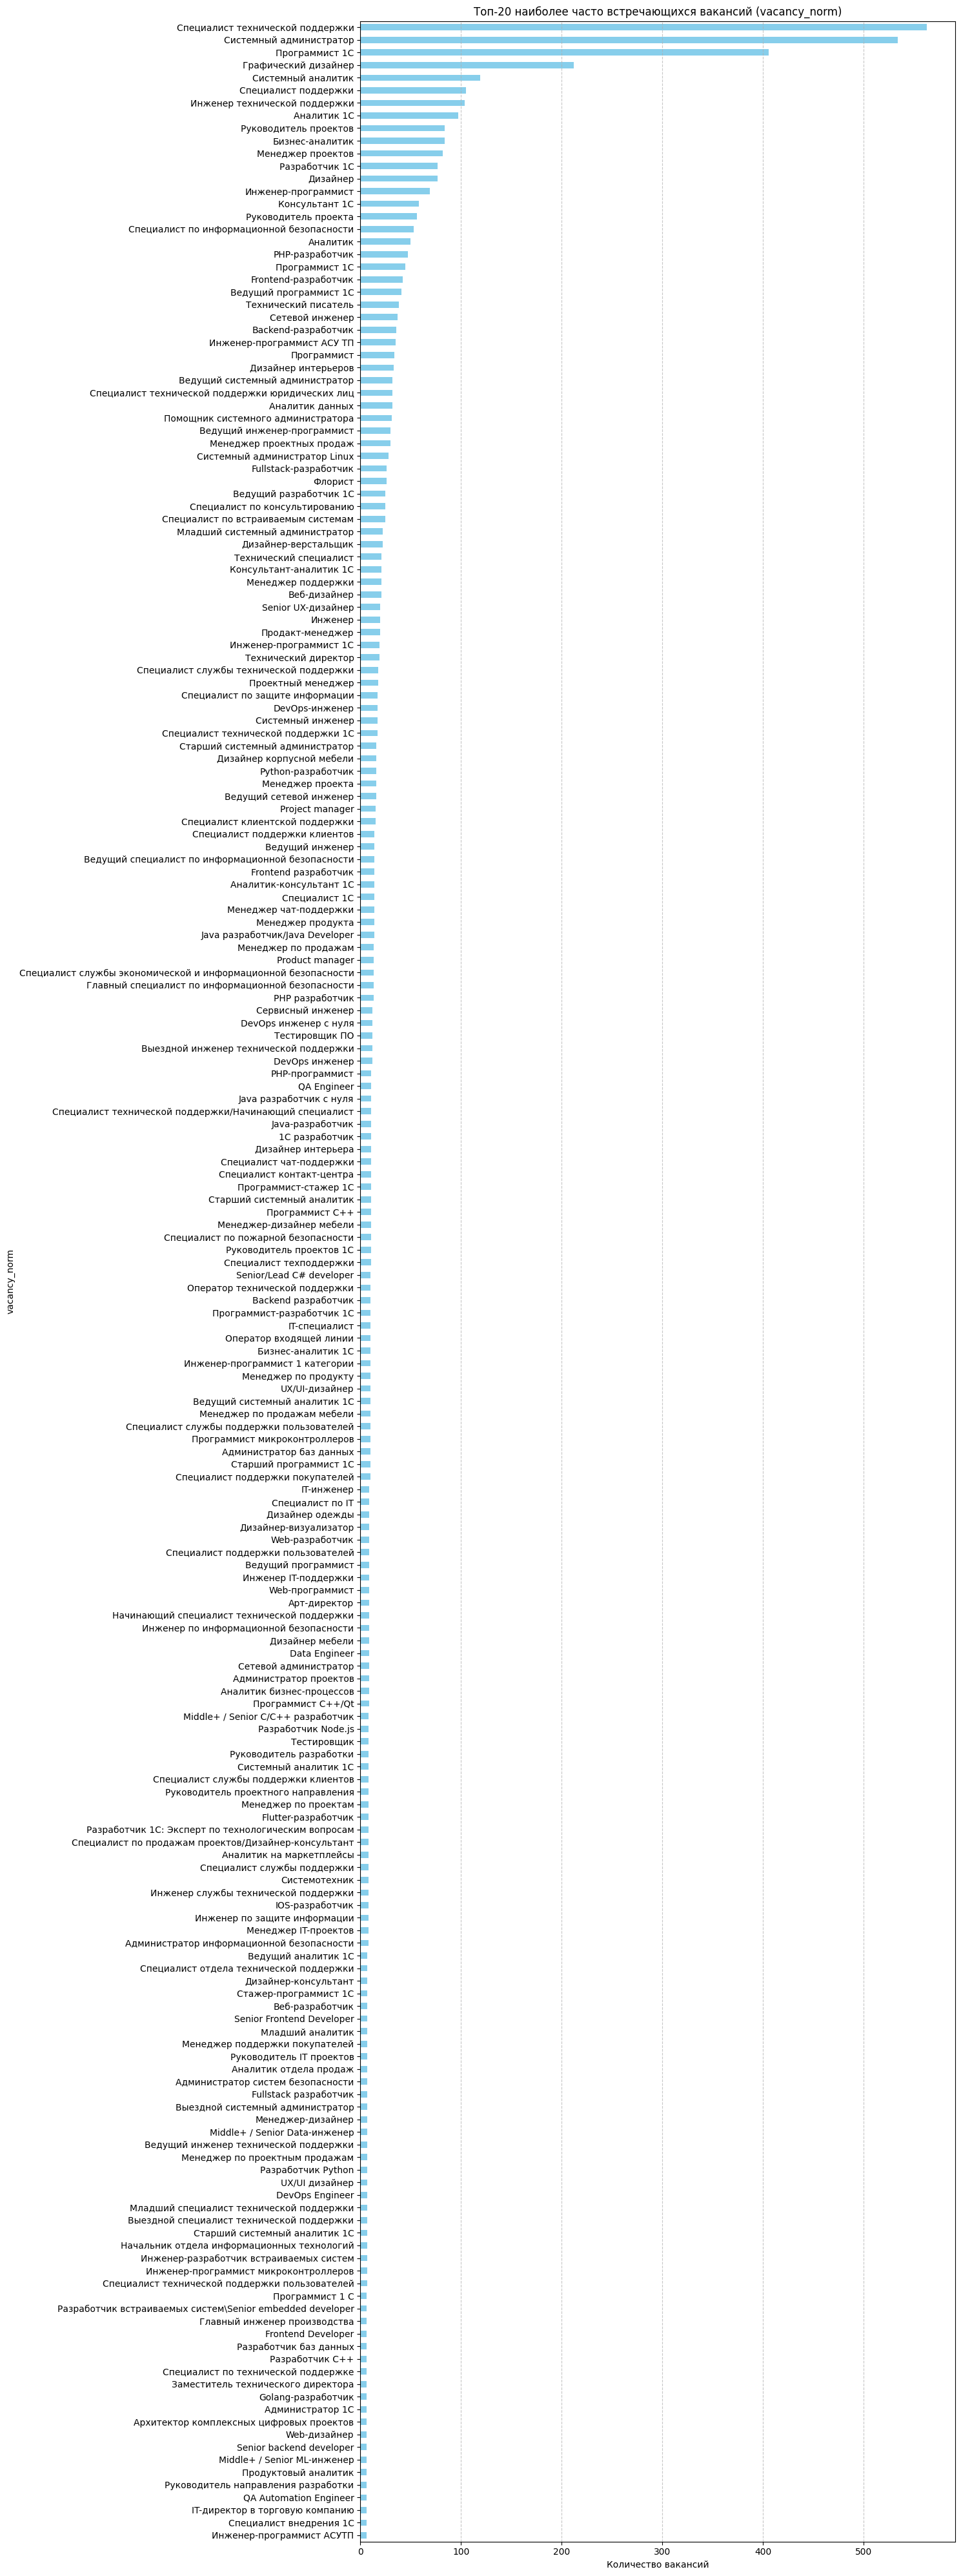

In [956]:
# Получаем распределение (частоты) вакансий
vacancy_counts = df['vacancy_norm'].value_counts()

# Выбираем топ-20 по частоте
top_vacancies = vacancy_counts.head(200)

# Построим горизонтальную столбчатую диаграмму
plt.figure(figsize=(15, 40))
top_vacancies.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Количество вакансий')
plt.title('Топ-20 наиболее часто встречающихся вакансий (vacancy_norm)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [957]:
df.loc[3851]

position                                              Дизайнер, художник
date                                            2025-06-05T10:13:24+0300
vacancy                   Дизайнер интерьеров (Менеджер по комплектации)
company                                                           Germes
city                                                               Тверь
experience                                                      1–3 года
employment                                              Полная занятость
schedule                                                     Полный день
salary from                                                     170000.0
salary to                                                       170000.0
currency                                                             RUB
skills                 [Проведение переговоров, Битрикс24, CRM, Оценк...
country                                                              NaN
industry                                           

In [1066]:
df['vacancy_norm'].value_counts()

vacancy_norm
Специалист технической поддержки      563
Системный администратор               534
Программист 1С                        451
Графический дизайнер                  212
Системный аналитик                    119
                                     ... 
Программист MS SQL, С#                  1
Ведущий программист-консультант 1С      1
Junior С# developer                     1
Программист 1С8                         1
Технический писатель, технолог          1
Name: count, Length: 5249, dtype: int64

In [1056]:
rear_vac = (df['vacancy_norm_1'].value_counts() < 100 ).index.to_list()

display(len(rear_vac))
display(rear_vac)

2927

['Специалист',
 'Аналитик',
 'Разработчик',
 'Программист',
 'Системный администратор',
 'Программист 1С',
 'Графический дизайнер',
 'Консультант',
 'Программист Ведущий 1С',
 'Специалист Ведущий 1С',
 'Инженер технической поддержки',
 'Аналитик 1С',
 'Разработчик Middle 1С',
 'Руководитель проектов',
 'Менеджер проектов',
 'Разработчик 1С',
 'Дизайнер',
 'Разработчик Ведущий 1С',
 'Консультант 1С',
 'Аналитик Ведущий 1С',
 'Руководитель проекта',
 'Разработчик Junior 1С',
 'Разработчик Senior 1С',
 'Технический писатель',
 'Сетевой инженер',
 'Дизайнер интерьеров',
 'Ведущий системный администратор',
 'Помощник системного администратора',
 'Менеджер проектных продаж',
 'Аналитик Старший 1С',
 'Системный администратор Linux',
 'Аналитик Младший 1С',
 'Флорист',
 'Младший системный администратор',
 'Специалист Младший 1С',
 'Дизайнер-верстальщик',
 'Менеджер поддержки',
 'Веб-дизайнер',
 'Инженер',
 'Продакт-менеджер',
 'Senior UX-дизайнер',
 'Программист Старший 1С',
 'Технический дире

In [960]:
top_n = 40
total_rows = len(df)

def top_n_vacancies_per_position(group, n=top_n):
    counts = group['vacancy_norm'].value_counts()
    top_vacancies = counts.head(n).index.tolist()
    return group[group['vacancy_norm'].isin(top_vacancies)]

df_top = df.groupby('position').apply(top_n_vacancies_per_position).reset_index(drop=True)

num_left = len(df_top)
percent_left = 100 * num_left / total_rows

print(f"Всего строк: {total_rows}")
print(f"Строк после выбора топ-{top_n} вакансий из каждой позиции: {num_left}")
print(f"Процент оставшихся строк: {percent_left:.2f}%")

Всего строк: 11651
Строк после выбора топ-40 вакансий из каждой позиции: 6211
Процент оставшихся строк: 53.31%


C:\Users\Андрей\AppData\Local\Temp\ipykernel_6032\2545972619.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df.groupby('position').apply(top_n_vacancies_per_position).reset_index(drop=True)


In [ ]:
#df_copy_vac['vacancy_norm'] = df['vacancy_norm']

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('ai-forever/sbert_large_mt_nlu_ru')  # модель
skill_embeddings = model.encode(unique_skills, show_progress_bar=True)

#### 2.3 Experience, Country, ...

In [818]:
df['experience'].value_counts()

experience
1–3 года       5731
3–6 лет        2917
Нет опыта      2301
Более 6 лет     502
Name: count, dtype: int64

In [183]:
# Сначала преобразуем столбец в строковый тип
df['experience'] = df['experience'].astype(str)

# Теперь можем безопасно заменять значения
experience_mapping = {
    'От 3 до 6 лет': '3–6 лет',
    'От 1 года до 3 лет': '1–3 года',
    'nan': '',  # Обрабатываем NaN как пустую строку
    'None': ''  # Обрабатываем None как пустую строку
}

df['experience'] = df['experience'].replace(experience_mapping)

# Показываем строки с пустыми значениями (после замены)
empty_experience = df[df['experience'].isin(['', 'nan', 'None'])]
display("Строки с пустыми значениями:")
display(empty_experience)


'Строки с пустыми значениями:'

position                      date  \
16      BI-аналитик, аналитик данных  2025-06-06T13:39:51+0300   
17      BI-аналитик, аналитик данных  2025-06-04T09:46:33+0300   
20      BI-аналитик, аналитик данных  2025-06-02T16:16:36+0300   
21      BI-аналитик, аналитик данных  2025-06-02T16:16:36+0300   
24      BI-аналитик, аналитик данных  2025-05-22T16:50:53+0300   
...                              ...                       ...   
1303      Технический директор (CTO)  2025-06-05T07:43:42+0300   
1304        Программист, разработчик  2025-05-30T14:13:17+0300   
1305        Программист, разработчик  2025-05-19T04:55:37+0300   
1306  Руководитель группы разработки  2025-05-14T09:09:03+0300   
1308         Системный администратор  2025-05-12T14:57:12+0300   

                                                vacancy  \
16                         Дата-аналитик / Data Analyst   
17                Дата-аналитик (Архитектор баз данных)   
20    Ассоциированный профессор (доцент, Автоматизац...   
21    Ассоциированный профессор (доцент, Автоматизац...   
24    Специалист по BI и Отчетности (BI & Reporting ...   
...                                                 ...   
1303                               Технический Директор   
1304                       Разработчик Node.js (NestJS)   
1305            Стажер аналитик-проектировщик (Ташкент)   
1306                                     Java Team Lead   
1308                 Администратор в компьютерном клубе   

                                                company     city experience  \
16                                 MAXWELL DISTRIBUTION   Астана              
17                   EUROPHARMA, ТМ (ТОО AK NIET GROUP)   Алматы              
20    НАО Атырауский университет нефти и газа имени ...   Атырау              
21    НАО Атырауский университет нефти и газа имени ...   Алматы              
24                                       D PARTNERS CO.   Алматы              
...                                                 ...      ...        ...   
1303                                       ОсОО Фастпэй   Бишкек              
1304                                           Invision  Ташкент              
1305                  Финансовые Информационные Системы  Ташкент              
1306                                         СимбирСофт  Ташкент              
1308                                          SAINT BAR  Ташкент              

            employment          schedule  salary from  salary to currency  \
16    Полная занятость       Полный день     154573.0   154573.0      RUB   
17    Полная занятость       Полный день      54101.0    54101.0      RUB   
20    Полная занятость       Полный день      48227.0    48227.0      RUB   
21    Полная занятость       Полный день      48227.0    48227.0      RUB   
24    Полная занятость  Удаленная работа      77286.0    92744.0      RUB   
...                ...               ...          ...        ...      ...   
1303  Полная занятость       Полный день      76398.0    76398.0      RUB   
1304  Проектная работа  Удаленная работа     110000.0   150000.0      RUB   
1305  Полная занятость  Удаленная работа      30000.0    30000.0      RUB   
1306  Полная занятость       Полный день     350000.0   500000.0      RUB   
1308  Полная занятость     Гибкий график       1113.0     1855.0      RUB   

                                                 skills     country industry  \
16    [SQL, Power BI, Бизнес-анализ, Data Mining, Ан...   Казахстан      NaN   
17    [Глубокий опыт в анализе и реорганизации табли...   Казахстан      NaN   
20                                    [Английский язык]   Казахстан      NaN   
21                                    [Английский язык]   Казахстан      NaN   
24    [Power BI, SQL, MS Excel, API, Управленческая ...   Казахстан      NaN   
...                                                 ...         ...      ...   
1303  [Руководство коллективом, Управление затратами...  Кыргызстан      NaN   
1304  [TypeS

In [184]:
# Проверяем распределение
print("Обновленное распределение:")
print(df['experience'].value_counts(dropna=False))

Обновленное распределение:
experience
1–3 года       5436
3–6 лет        2750
Нет опыта      2184
                842
Более 6 лет     439
Name: count, dtype: int64


In [186]:
df[df['experience'] == '']['city'].value_counts()

city
Алматы              366
Астана              205
Бишкек               73
Шымкент              25
Караганда            25
Усть-Каменогорск     18
Тараз                12
Актобе               11
Костанай             11
Минск                11
Атырау               10
Павлодар              8
Петропавловск         7
Семей                 6
Уральск               6
Ташкент               4
Кокшетау              4
Актау                 4
Кызылорда             3
Таиланд               3
Тбилиси               3
Талдыкорган           3
Конаев                2
ОАЭ                   2
Жезказган             2
Экибастуз             2
Туркестан             2
Талгар                2
Гродно                1
Шу                    1
Жлобин                1
Каскелен              1
Темиртау              1
Китай                 1
Сербия                1
США                   1
Рудный                1
Ош                    1
Балыкчы               1
Могилев               1
Name: count, dtype: int64

In [ ]:
# Загружаем данные первого этапа

df_start = pd.read_csv('full_data_stage_1.csv')

In [162]:
df_start = df_start.dropna(subset=['skills'])

In [ ]:
df_to_ml = df_start[df_start['experience'] == '']

In [164]:
df_to_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 842 entries, 16 to 1308
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          842 non-null    object 
 1   date              842 non-null    object 
 2   vacancy           842 non-null    object 
 3   company           842 non-null    object 
 4   city              842 non-null    object 
 5   experience        0 non-null      object 
 6   employment        842 non-null    object 
 7   schedule          842 non-null    object 
 8   salary from       842 non-null    float64
 9   salary to         842 non-null    float64
 10  currency          842 non-null    object 
 11  skills            842 non-null    object 
 12  url               842 non-null    object 
 13  ID                842 non-null    float64
 14  country           842 non-null    object 
 15  industry          0 non-null      object 
 16  text              841 non-null    object 
 17  

In [167]:
df_to_ml[['text','employment', 'schedule']]

text        employment  \
16    Компания ТОО \nMaxwell\n \nDistribution\n Каза...  Полная занятость   
17    AQ NIET GROUP – казахстанская группа компании ...  Полная занятость   
20    Требования: \nвысшее (или послевузовское) обра...  Полная занятость   
21    Требования: \nвысшее (или послевузовское) обра...  Полная занятость   
24    Мы объединяем компетенции в области анализа да...  Полная занятость   
...                                                 ...               ...   
1303  Обязанности:\n \n \nРуководство техническим де...  Полная занятость   
1304  Ищем опытного \nBackend-разработчика\n для кас...  Проектная работа   
1305  Мы занимаемся разработкой и внедрением систем,...  Полная занятость   
1306  Наша компания занимается крупными амбициозными...  Полная занятость   
1308  Обязанности:\n \nПроверять чистоту игрового за...  Полная занятость   

              schedule  
16         Полный день  
17         Полный день  
20         Полный день  
21         Полный день  
24    Удаленная работа  
...                ...  
1303       Полный день  
1304  Удаленная работа  
1305  Удаленная работа  
1306       Полный день  
1308     Гибкий график  

[842 rows x 3 columns]

In [169]:
df_to_ml.to_csv('df_to_ml_experience.csv')

In [ ]:
# здесь с файлом работала модель Mistral , код и промпт см в файле LLM Mistral API labeling.ipynb

In [190]:

df_updated = pd.read_csv("df_to_ml_experience.csv")  # только строки с обновлённым experience


In [191]:
df_updated['experience'].value_counts()

experience
1–3 года                                289
3–6 лет                                 165
Нет опыта                               117
Более 6 лет                              63
2–3 года                                  3
2 года                                    2
5–6 лет                                   1
Опыт работы на аналогичной должности      1
Опыт работы обязателен!!!                 1
Name: count, dtype: int64

In [192]:
# Маппинг
normalize_map = {
    "1–3 года": "1–3 года",
    "2–3 года": "1–3 года",
    "2 года": "1–3 года",
    "Опыт работы обязателен!!!": "1–3 года",

    "3–6 лет": "3–6 лет",
    "5–6 лет": "3–6 лет",
    "Опыт работы на аналогичной должности": "3–6 лет",

    "Нет опыта": "Нет опыта",

    "Более 6 лет": "Более 6 лет"
}

# Заменяем значения
df_updated['experience'] = df_updated['experience'].map(normalize_map).fillna(df_updated['experience'])

# Проверим результат
print(df_updated['experience'].value_counts())

experience
1–3 года       295
3–6 лет        167
Нет опыта      117
Более 6 лет     63
Name: count, dtype: int64


In [200]:
df_updated['experience'].value_counts(dropna=False)

experience
1–3 года       295
NaN            200
3–6 лет        167
Нет опыта      117
Более 6 лет     63
Name: count, dtype: int64

In [193]:
df_updated

Unnamed: 0                        position                      date  \
0            16    BI-аналитик, аналитик данных  2025-06-06T13:39:51+0300   
1            17    BI-аналитик, аналитик данных  2025-06-04T09:46:33+0300   
2            20    BI-аналитик, аналитик данных  2025-06-02T16:16:36+0300   
3            21    BI-аналитик, аналитик данных  2025-06-02T16:16:36+0300   
4            24    BI-аналитик, аналитик данных  2025-05-22T16:50:53+0300   
..          ...                             ...                       ...   
837        1303      Технический директор (CTO)  2025-06-05T07:43:42+0300   
838        1304        Программист, разработчик  2025-05-30T14:13:17+0300   
839        1305        Программист, разработчик  2025-05-19T04:55:37+0300   
840        1306  Руководитель группы разработки  2025-05-14T09:09:03+0300   
841        1308         Системный администратор  2025-05-12T14:57:12+0300   

                                               vacancy  \
0                         Дата-аналитик / Data Analyst   
1                Дата-аналитик (Архитектор баз данных)   
2    Ассоциированный профессор (доцент, Автоматизац...   
3    Ассоциированный профессор (доцент, Автоматизац...   
4    Специалист по BI и Отчетности (BI & Reporting ...   
..                                                 ...   
837                               Технический Директор   
838                       Разработчик Node.js (NestJS)   
839            Стажер аналитик-проектировщик (Ташкент)   
840                                     Java Team Lead   
841                 Администратор в компьютерном клубе   

                                               company     city   experience  \
0                                 MAXWELL DISTRIBUTION   Астана      3–6 лет   
1                   EUROPHARMA, ТМ (ТОО AK NIET GROUP)   Алматы     1–3 года   
2    НАО Атырауский университет нефти и газа имени ...   Атырау  Более 6 лет   
3    НАО Атырауский университет нефти и газа имени ...   Алматы  Более 6 лет   
4                                       D PARTNERS CO.   Алматы          NaN   
..                                                 ...      ...          ...   
837                                       ОсОО Фастпэй   Бишкек  Более 6 лет   
838                                           Invision  Ташкент      3–6 лет   
839                  Финансовые Информационные Системы  Ташкент    Нет опыта   
840                                         СимбирСофт  Ташкент  Более 6 лет   
841                                          SAINT BAR  Ташкент          NaN   

           employment          schedule  salary from  ...  industry  \
0    Полная занятость       Полный день     154573.0  ...       NaN   
1    Полная занятость       Полный день      54101.0  ...       NaN   
2    Полная занятость       Полный день      48227.0  ...       NaN   
3    Полная занятость       Полный день      48227.0  ...       NaN   
4    Полная занятость  Удаленная работа      77286.0  ...       NaN   
..                ...               ...          ...  ...       ...   
837  Полная занятость       Полный день      76398.0  ...       NaN   
838  Проектная работа  Удаленная работа     110000.0  ...       NaN   
839  Полная занятость  Удаленная работа      30000.0  ...       NaN   
840  Полная занятость       Полный день     350000.0  ...       NaN   
841  Полная занятость     Гибкий график       1113.0  ...       NaN   

                                                  text period of pay level  \
0    Компания ТОО \nMaxwell\n \nDistribution\n Каза...           NaN   NaN   
1    AQ NIET GROUP – казахстанская группа компании ...           NaN   NaN   
2    Требования: \nвысшее (или послевузовское) обра...           NaN   NaN   
3    Требования: \nвысшее (или послевузовское) обра...           NaN   NaN   
4    Мы объединяем компетенции в области анализа да...           NaN   NaN   
..                                                 ...           ...   ...   
837  Обязанности:\n \n 

In [194]:
# Восстанавливаем индекс
df_updated.set_index('Unnamed: 0', inplace=True)

In [196]:
# Обновим только те строки, где в df['experience'] пусто
mask_empty = df['experience'].isna() | (df['experience'].astype(str).str.strip() == '')

In [197]:
# Убедимся, что индексы совпадают
intersecting_indices = df.index[mask_empty].intersection(df_updated.index)

In [1069]:
# Выполняем замену
df.loc[intersecting_indices, 'experience'] = df_updated.loc[intersecting_indices, 'experience']

In [1070]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11651 entries, 0 to 18691
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   position             11651 non-null  object 
 1   date                 11651 non-null  object 
 2   vacancy              11651 non-null  object 
 3   company              11651 non-null  object 
 4   city                 11651 non-null  object 
 5   experience           11451 non-null  object 
 6   employment           11651 non-null  object 
 7   schedule             11651 non-null  object 
 8   salary from          11651 non-null  float64
 9   salary to            11651 non-null  float64
 10  currency             11651 non-null  object 
 11  skills               11651 non-null  object 
 12  country              842 non-null    object 
 13  industry             10800 non-null  object 
 14  skills_clean         11651 non-null  object 
 15  skills_clean_norm    11651 non-null  obje

In [1071]:
df = df.dropna( subset=['experience'])

In [1072]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11451 entries, 0 to 18691
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   position             11451 non-null  object 
 1   date                 11451 non-null  object 
 2   vacancy              11451 non-null  object 
 3   company              11451 non-null  object 
 4   city                 11451 non-null  object 
 5   experience           11451 non-null  object 
 6   employment           11451 non-null  object 
 7   schedule             11451 non-null  object 
 8   salary from          11451 non-null  float64
 9   salary to            11451 non-null  float64
 10  currency             11451 non-null  object 
 11  skills               11451 non-null  object 
 12  country              642 non-null    object 
 13  industry             10800 non-null  object 
 14  skills_clean         11451 non-null  object 
 15  skills_clean_norm    11451 non-null  obje

In [ ]:
#df = df.loc[df['experience'] != '']

In [222]:
df['position'].value_counts()

position
Программист, разработчик                        2765
Специалист технической поддержки                2093
Дизайнер, художник                              1192
Системный администратор                         1070
Руководитель проектов                            955
Аналитик                                         775
Специалист по информационной безопасности        456
Менеджер продукта                                308
Системный аналитик                               210
Тестировщик                                      210
Бизнес-аналитик                                  201
Системный инженер                                181
Сетевой инженер                                  173
BI-аналитик, аналитик данных                     134
Методолог                                        120
DevOps-инженер                                   110
Руководитель группы разработки                   107
Технический директор (CTO)                        95
Технический писатель                 

In [203]:
df['employment'].value_counts()

employment
Полная занятость       11181
Частичная занятость      213
Проектная работа          57
Name: count, dtype: int64

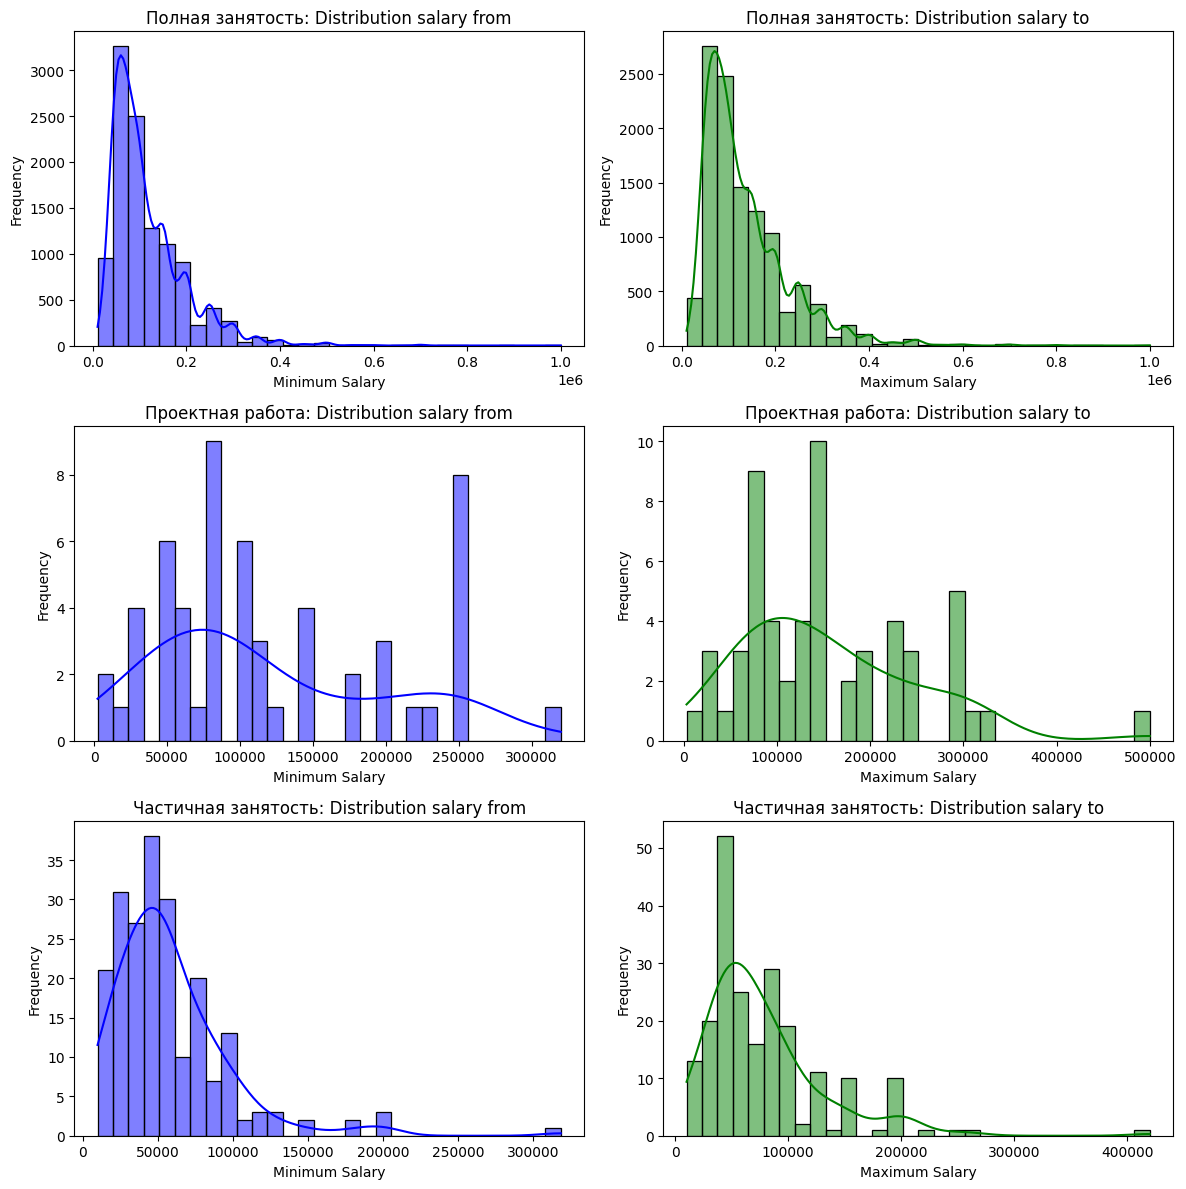

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

# Группируем по типу занятости
grouped_by_emp = df.groupby('employment')

# Определяем типы занятости
employment_types = sorted(list(grouped_by_emp.groups.keys()))

# Строим графики друг над другом
fig, axes = plt.subplots(len(employment_types), 2, figsize=(12, 12))

for i, emp_type in enumerate(employment_types):
    group = grouped_by_emp.get_group(emp_type)
    
    # Гистограмма минимальной зарплаты
    sns.histplot(group['salary from'], ax=axes[i][0], bins=30, kde=True, color='blue')
    axes[i][0].set_title(f'{emp_type}: Distribution salary from')
    axes[i][0].set_xlabel('Minimum Salary')
    axes[i][0].set_ylabel('Frequency')
    
    # Гистограмма максимальной зарплаты
    sns.histplot(group['salary to'], ax=axes[i][1], bins=30, kde=True, color='green')
    axes[i][1].set_title(f'{emp_type}: Distribution salary to')
    axes[i][1].set_xlabel('Maximum Salary')
    axes[i][1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [204]:
df['schedule'].value_counts()

schedule
Полный день         7621
Удаленная работа    3264
Сменный график       364
Гибкий график        163
Вахтовый метод        39
Name: count, dtype: int64

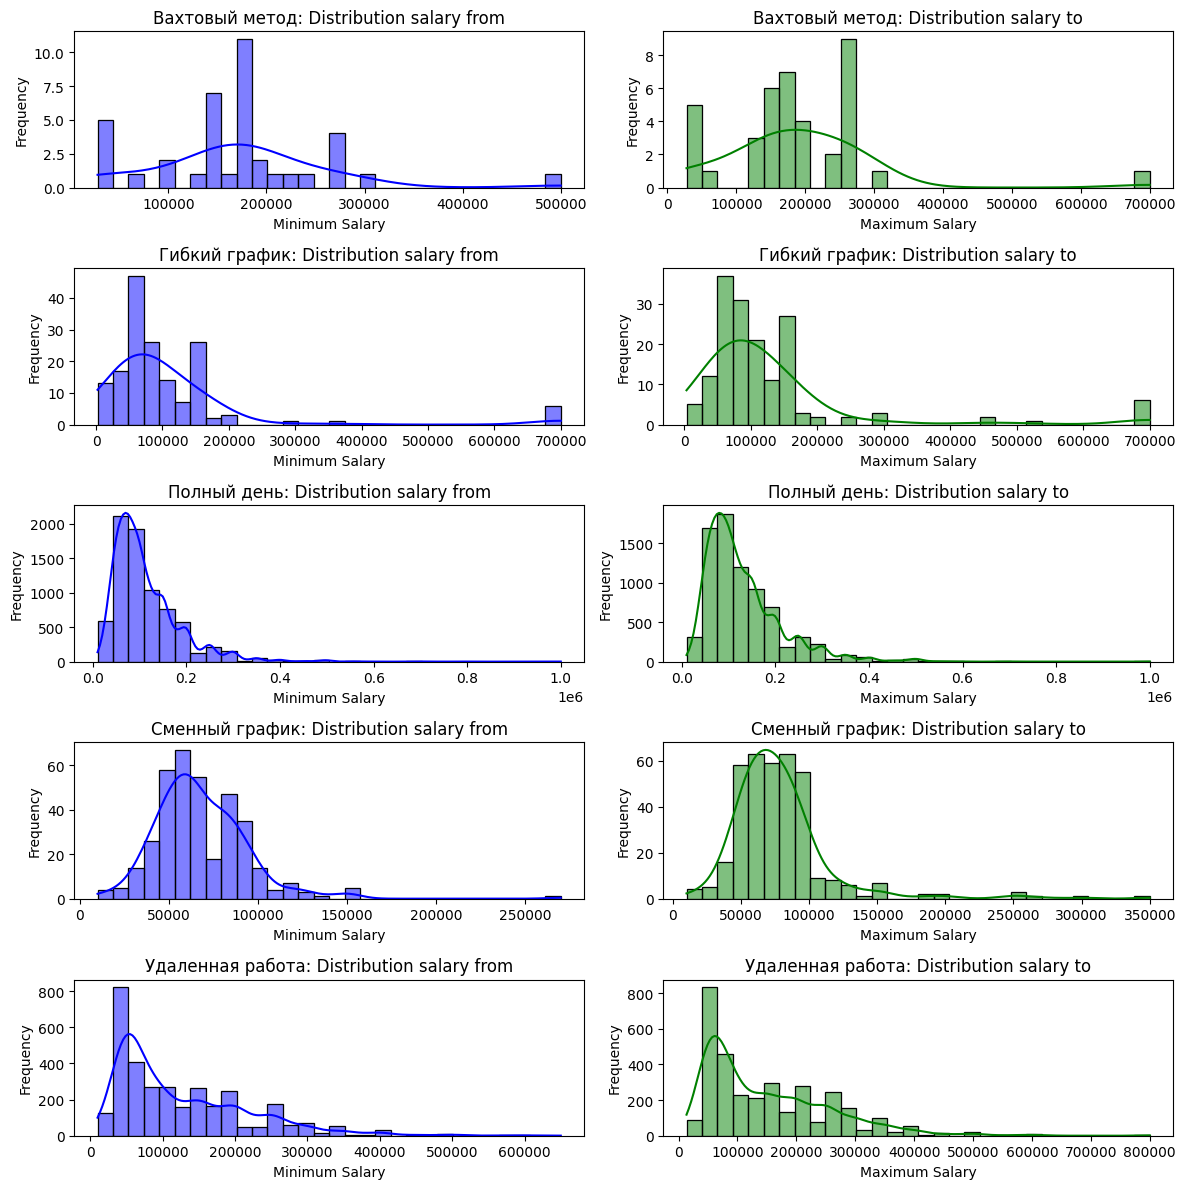

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

# Группируем по расписанию
grouped_by_schedule = df.groupby('schedule')

# Определяем виды расписания
schedules = sorted(list(grouped_by_schedule.groups.keys()))

# Создаём сетки графиков
fig, axes = plt.subplots(len(schedules), 2, figsize=(12, 12))

for i, sched in enumerate(schedules):
    group = grouped_by_schedule.get_group(sched)
    
    # Первая колонка — гистограмма минимальной зарплаты
    sns.histplot(group['salary from'], ax=axes[i][0], bins=30, kde=True, color='blue')
    axes[i][0].set_title(f'{sched}: Distribution salary from')
    axes[i][0].set_xlabel('Minimum Salary')
    axes[i][0].set_ylabel('Frequency')
    
    # Вторая колонка — гистограмма максимальной зарплаты
    sns.histplot(group['salary to'], ax=axes[i][1], bins=30, kde=True, color='green')
    axes[i][1].set_title(f'{sched}: Distribution salary to')
    axes[i][1].set_xlabel('Maximum Salary')
    axes[i][1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [1073]:
df['country'].value_counts()

country
Казахстан         564
Кыргызстан         53
Беларусь           12
Другие регионы      7
Грузия              3
Узбекистан          3
Name: count, dtype: int64

In [ ]:
with pd.option_context('display.max_rows', 100):
    display(df['city'].value_counts().head(100))

In [224]:
df_copy = df.copy()

In [211]:
df_copy.to_csv('df_city_country.csv')

In [234]:
df_temp_city = pd.read_csv('df_city_country.csv')
df_temp_city['country'].value_counts(dropna= False)

country
Россия            10759
Казахстан           565
Кыргызстан           53
NaN                  37
Беларусь             13
Другие регионы        7
Таиланд               3
Грузия                3
Узбекистан            3
США                   2
ОАЭ                   2
Китай                 1
Сербия                1
Белоруссия            1
Украина               1
Name: count, dtype: int64

In [ ]:
df_temp_city

In [236]:
# Переименуем индексную колонку
df_temp_city.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

# Убедимся, что типы совпадают
df_temp_city['index'] = df_temp_city['index'].astype(int)

# Установим индекс
df_temp_city.set_index('index', inplace=True)

# Обновим колонку country в df_copy
df_copy.loc[df_temp_city.index, 'country'] = df_temp_city['country']

In [ ]:
df_copy[df_copy['country'].isna()].to_csv('city_country_2.csv')

In [ ]:
# здесь с файлом работала модель см файл LLM Mistral API labeling.ipynb

In [ ]:
df_temp_city_2 = pd.read_csv('city_country_2.csv')

In [ ]:
# Переименуем индексную колонку
df_temp_city_2.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

# Убедимся, что типы совпадают
df_temp_city_2['index'] = df_temp_city_2['index'].astype(int)

# Установим индекс
df_temp_city_2.set_index('index', inplace=True)

# Обновим колонку country в df_copy
df_copy.loc[df_temp_city_2.index, 'country'] = df_temp_city_2['country']

#### 2. EDA

is_normal_salary from  \
position                                                             
BI-аналитик, аналитик данных                                 False   
DevOps-инженер                                                True   
Аналитик                                                     False   
Арт-директор, креативный директор                             True   
Бизнес-аналитик                                              False   
Гейм-дизайнер                                            too_small   
Дата-сайентист                                                True   
Дизайнер, художник                                           False   
Директор по информационным технологиям (CIO)                 False   
Менеджер продукта                                            False   
Методолог                                                    False   
Программист, разработчик                                     False   
Продуктовый аналитик                                          True   
Руководитель группы разработки                               False   
Руководитель отдела аналитики                            too_small   
Руководитель проектов                                        False   
Сетевой инженер                                              False   
Системный администратор                                      False   
Системный аналитик                                           False   
Системный инженер                                            False   
Специалист по информационной безопасности                    False   
Специалист технической поддержки                             False   
Тестировщик                                                  False   
Технический директор (CTO)                                   False   
Технический писатель                                         False   

                                             is_normal_salary to  \
position                                                           
BI-аналитик, аналитик данных                               False   
DevOps-инженер                                              True   
Аналитик                                                   False   
Арт-директор, креативный директор                          False   
Бизнес-аналитик                                            False   
Гейм-дизайнер                                          too_small   
Дата-сайентист                                             False   
Дизайнер, художник                                         False   
Директор по информационным технологиям (CIO)               False   
Менеджер продукта                                          False   
Методолог                                                  False   
Программист, разработчик                                   False   
Продуктовый аналитик                                       False   
Руководитель группы разработки                             False   
Руководитель отдела аналитики                          too_small   
Руководитель проектов                                      False   
Сетевой инженер                                            False   
Системный администратор                                    False   
Системный аналитик                                         False   
Системный инженер                                          False   
Специалист по информационной безопасности                  False   
Специалист технической поддержки                           False   
Тестировщик                                                False   
Технический директор (CTO)                                 False   
Технический писатель                                       False   

                                             n_removed_salary from  \
position                                                             
BI-аналитик, аналитик данных                                     4   
DevOps-инженер                                                   0   
Аналитик                             

c:\Users\Андрей\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


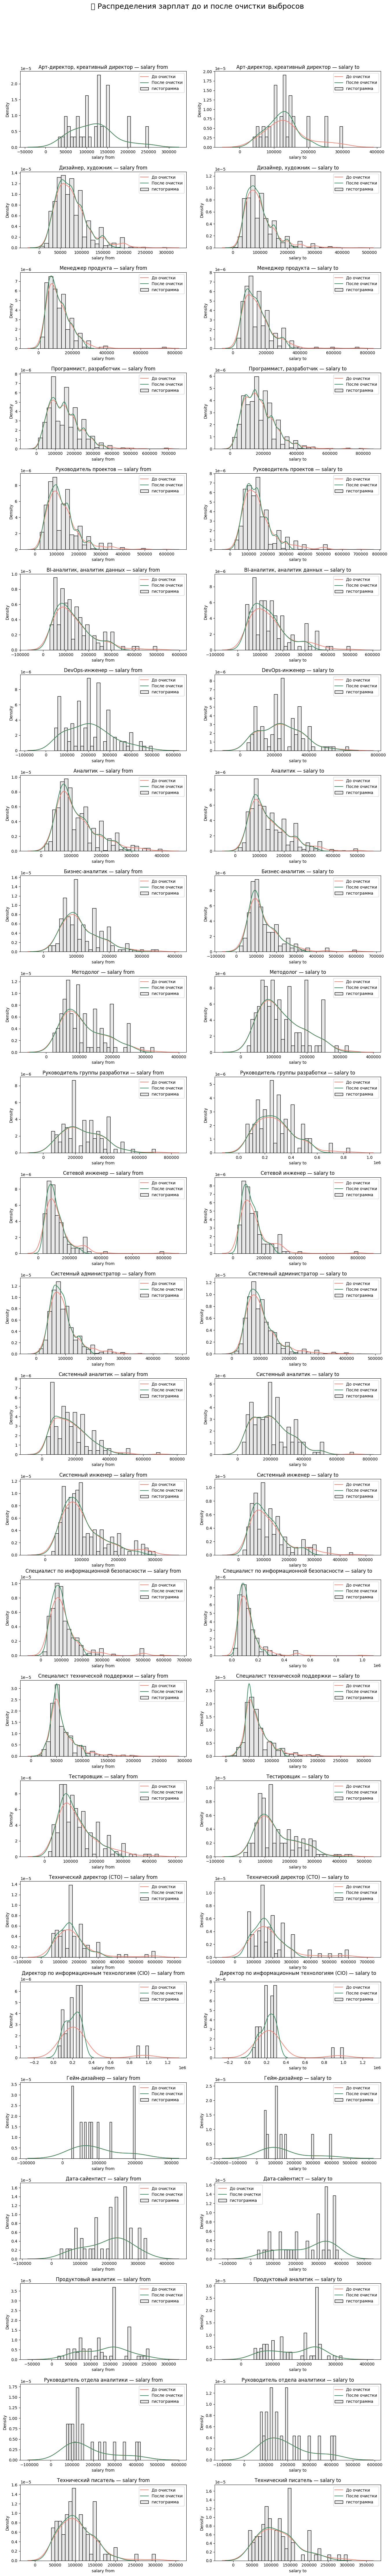

In [ ]:


# Создаём колонки для нормализованных значений
df_copy['salary from norm'] = np.nan
df_copy['salary to norm'] = np.nan

# Для сбора отчёта
report = []

# Функция очистки и нормализации
def process_series(series, colname, position):
    n_total = len(series.dropna())

    if n_total <= 20:
        # малый объём — не трогаем
        report.append({
            'position': position,
            'column': colname,
            'is_normal': 'too_small',
            'n_total': n_total,
            'n_filtered': n_total,
            'n_removed': 0
        })
        return series  # возвращаем как есть

    # нормальный тест на нормальность
    stat, p = normaltest(series)
    is_normal = p > 0.05

    if is_normal:
        mu, sigma = series.mean(), series.std()
        mask = (series >= mu - 3 * sigma) & (series <= mu + 3 * sigma)
    else:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        mask = (series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)

    n_filtered = mask.sum()
    n_removed = n_total - n_filtered

    report.append({
        'position': position,
        'column': colname,
        'is_normal': is_normal,
        'n_total': n_total,
        'n_filtered': n_filtered,
        'n_removed': n_removed
    })

    return series.where(mask)

# Обработка по каждой позиции
positions = df_copy['position'].unique()
for pos in positions:
    mask_pos = df_copy['position'] == pos
    for col in ['salary from', 'salary to']:
        result = process_series(df_copy.loc[mask_pos, col], col, pos)
        df_copy.loc[mask_pos, f'{col} norm'] = result

# Вывод статистики
report_df = pd.DataFrame(report)
'''
report_df = pd.DataFrame(report)
for pos in positions:
    sub = report_df[report_df['position'] == pos]
    print(f"\n🧾 Позиция: {pos}")
    for _, row in sub.iterrows():
        status = "нормальное" if row['is_normal'] else "не нормальное"
        print(f"  ▸ {row['column']}: распределение {status}, удалено выбросов: {row['n_removed']} из {row['n_total']}")



'''

# Форматируем и выводим таблицу
report_summary = report_df.pivot(index='position', columns='column', values=['is_normal', 'n_removed', 'n_total'])
report_summary.columns = ['_'.join(col).strip() for col in report_summary.columns.values]

# Покажем таблицу
display(report_summary)

# Визуализация: stacked строками по position

n_positions = len(positions)
fig, axs = plt.subplots(n_positions, 2, figsize=(14, n_positions * 3.5))
fig.tight_layout(pad=4)


for idx, pos in enumerate(positions):
    for j, col in enumerate(['salary from', 'salary to']):
        ax = axs[idx][j]
        before = df_copy[df_copy['position'] == pos][col]
        after = df_copy[df_copy['position'] == pos][f'{col} norm']

        sns.histplot(before, ax=ax, bins=30, stat='density', color='lightgray', alpha=0.5, label='гистограмма')
        sns.kdeplot(before, ax=ax, color='salmon', label='До очистки')
        sns.kdeplot(after.dropna(), ax=ax, color='seagreen', label='После очистки')
        
        #sns.kdeplot(before, ax=ax, label='До очистки', color='salmon', fill=True)
        #sns.kdeplot(after.dropna(), ax=ax, label='После очистки', color='seagreen', fill=True)
        
        ax.set_title(f"{pos} — {col}")
        ax.legend()

plt.suptitle("📊 Распределения зарплат до и после очистки выбросов", fontsize=18, y=1.02)
plt.show()


In [229]:
for pos in positions:
    pos_mask = df_copy['position'] == pos

    for col in ['salary from', 'salary to']:
        # очищаем колонку от выбросов
        cleaned_series = process_series(
            df_copy.loc[pos_mask, col],
            col,
            pos
        )

        # сохраняем очищенные значения в новую колонку
        df_copy.loc[pos_mask, f'{col} norm'] = cleaned_series

In [ ]:
# не забудь перед обучением 
# df_train = df_copy.dropna(subset=['salary from norm', 'salary to norm'])

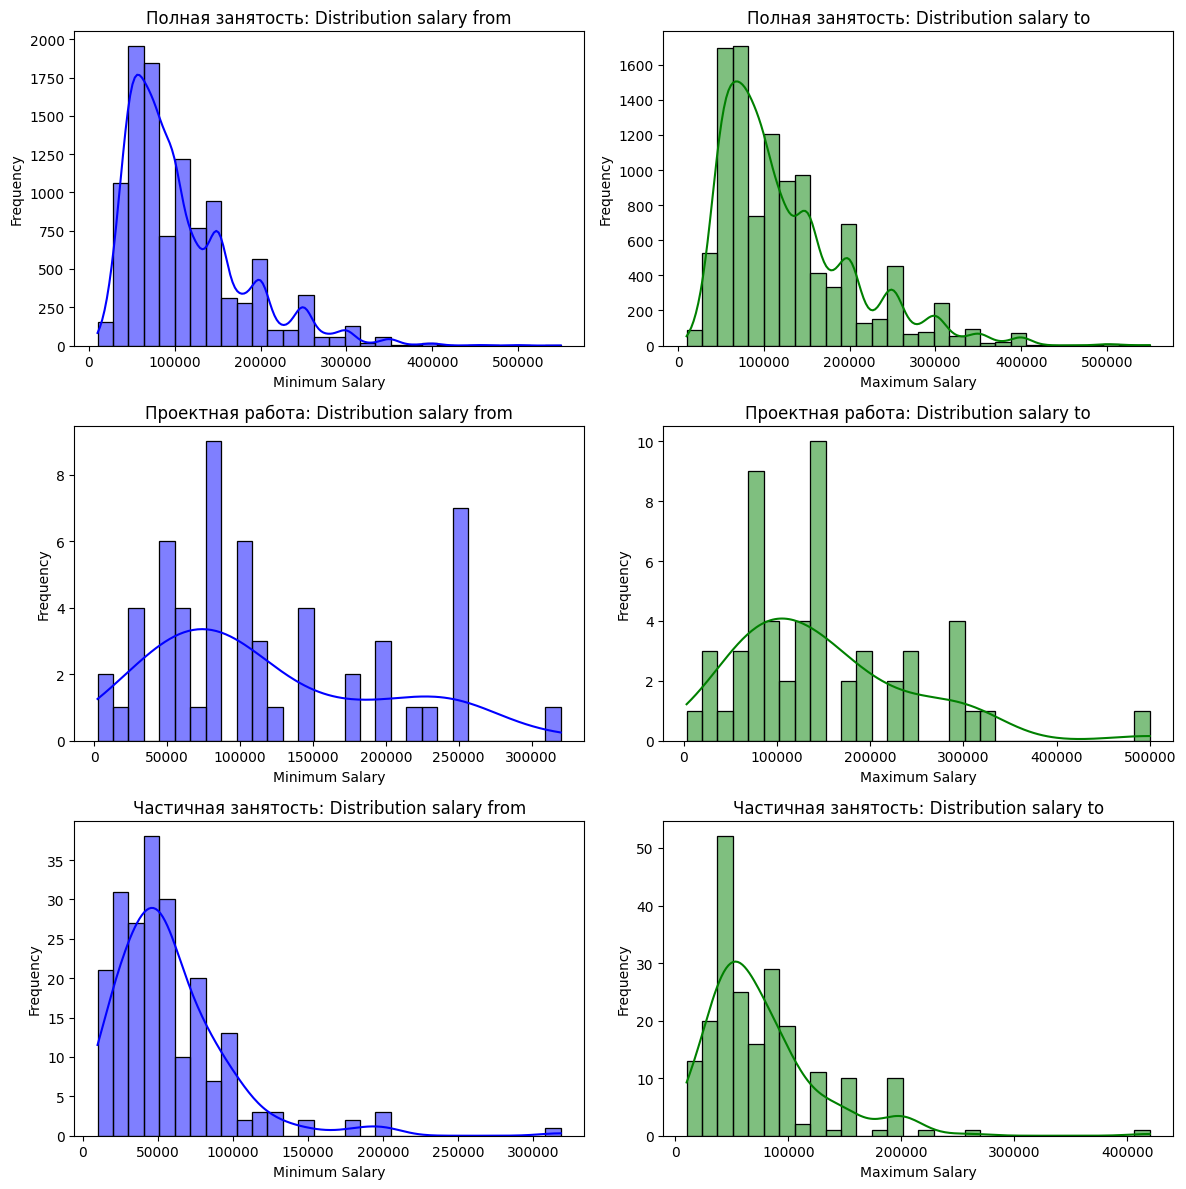

In [231]:
# Группируем по типу занятости
grouped_by_emp = df_copy.groupby('employment')

# Определяем типы занятости
employment_types = sorted(list(grouped_by_emp.groups.keys()))

# Строим графики друг над другом
fig, axes = plt.subplots(len(employment_types), 2, figsize=(12, 12))

for i, emp_type in enumerate(employment_types):
    group = grouped_by_emp.get_group(emp_type)
    
    # Гистограмма минимальной зарплаты
    sns.histplot(group['salary from norm'], ax=axes[i][0], bins=30, kde=True, color='blue')
    axes[i][0].set_title(f'{emp_type}: Distribution salary from')
    axes[i][0].set_xlabel('Minimum Salary')
    axes[i][0].set_ylabel('Frequency')
    
    # Гистограмма максимальной зарплаты
    sns.histplot(group['salary to norm'], ax=axes[i][1], bins=30, kde=True, color='green')
    axes[i][1].set_title(f'{emp_type}: Distribution salary to')
    axes[i][1].set_xlabel('Maximum Salary')
    axes[i][1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

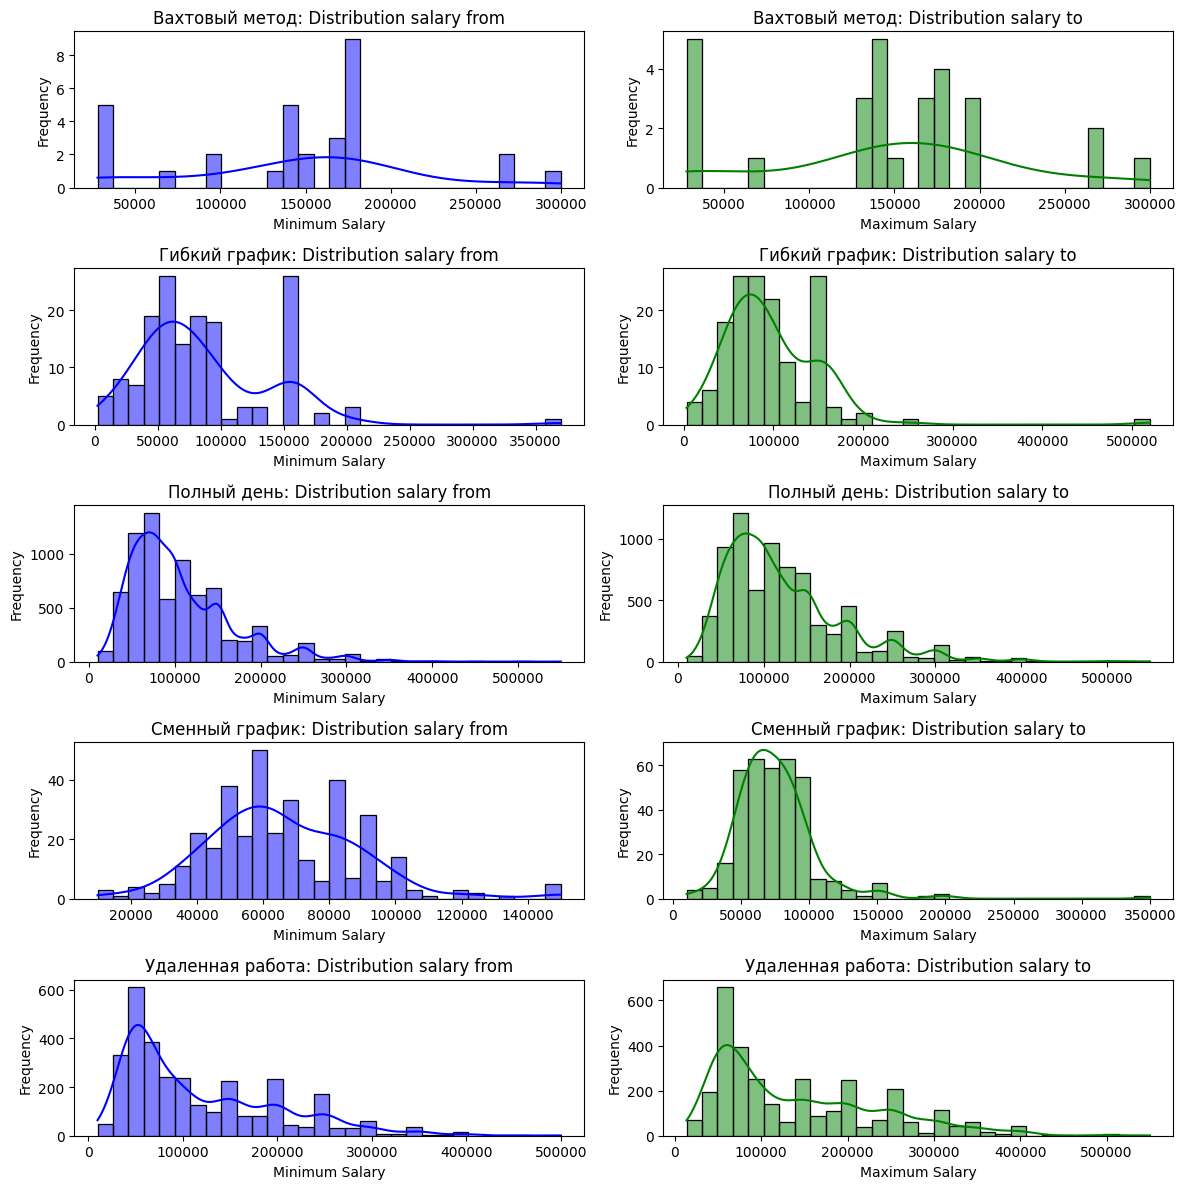

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

# Группируем по расписанию
grouped_by_schedule = df_copy.groupby('schedule')

# Определяем виды расписания
schedules = sorted(list(grouped_by_schedule.groups.keys()))

# Создаём сетки графиков
fig, axes = plt.subplots(len(schedules), 2, figsize=(12, 12))

for i, sched in enumerate(schedules):
    group = grouped_by_schedule.get_group(sched)
    
    # Первая колонка — гистограмма минимальной зарплаты
    sns.histplot(group['salary from norm'], ax=axes[i][0], bins=30, kde=True, color='blue')
    axes[i][0].set_title(f'{sched}: Distribution salary from')
    axes[i][0].set_xlabel('Minimum Salary')
    axes[i][0].set_ylabel('Frequency')
    
    # Вторая колонка — гистограмма максимальной зарплаты
    sns.histplot(group['salary to norm'], ax=axes[i][1], bins=30, kde=True, color='green')
    axes[i][1].set_title(f'{sched}: Distribution salary to')
    axes[i][1].set_xlabel('Maximum Salary')
    axes[i][1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [237]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11451 entries, 0 to 18691
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   position           11451 non-null  object 
 1   date               11451 non-null  object 
 2   vacancy            11451 non-null  object 
 3   company            11451 non-null  object 
 4   city               11451 non-null  object 
 5   experience         11451 non-null  object 
 6   employment         11451 non-null  object 
 7   schedule           11451 non-null  object 
 8   salary from        11451 non-null  float64
 9   salary to          11451 non-null  float64
 10  currency           11451 non-null  object 
 11  skills             11451 non-null  object 
 12  country            11414 non-null  object 
 13  industry           10800 non-null  object 
 14  skills_clean       11451 non-null  object 
 15  skills_clean_norm  11451 non-null  object 
 16  salary from norm   10967 no

In [262]:
df_copy['country'].value_counts(dropna='False')

country
Россия            10796
Казахстан           565
Кыргызстан           53
Беларусь             13
Другие регионы        7
Таиланд               3
Грузия                3
Узбекистан            3
США                   2
ОАЭ                   2
Китай                 1
Сербия                1
Белоруссия            1
Украина               1
Name: count, dtype: int64

In [250]:

# отфильтруем только непустые страны
df_train = df_copy.dropna(subset=['salary from norm', 'salary to norm', 'country', 'position'])

# Группируем по position и country с агрегацией
position_country_stats = df_train.groupby(['position', 'country'])[
    ['salary from norm', 'salary to norm']
].agg(['mean', 'median', 'std', 'count']).round(1)


df_sorted = position_country_stats.reset_index()

df_sorted = df_sorted.sort_values(
    by=['position', ('salary from norm', 'median')],
    ascending=[True, False]
)

# Если нужно, вернуть MultiIndex
df_sorted = df_sorted.set_index(['position', 'country'])



# Покажем (можно сортировать по медиане зарплаты FROM по убыванию)
with pd.option_context('display.max_rows', 100):
    display(df_sorted)

salary from norm  \
                                                                        mean   
position                                     country                           
BI-аналитик, аналитик данных                 Россия                 123140.2   
                                             Казахстан               76282.0   
DevOps-инженер                               Россия                 206672.0   
                                             Казахстан               96372.0   
Аналитик                                     Россия                 113657.9   
                                             Казахстан               63623.5   
Арт-директор, креативный директор            США                    200000.0   
                                             Россия                 108987.9   
                                             Казахстан               91198.0   
Бизнес-аналитик                              Россия                 112710.3   
                                             Казахстан               81150.8   
                                             Кыргызстан              62916.0   
Гейм-дизайнер                                Россия                  95000.0   
Дата-сайентист                               Россия                 194651.2   
Дизайнер, художник                           Другие регионы         160000.0   
                                             ОАЭ                    160000.0   
                                             Россия                  76914.5   
                                             Грузия                  60000.0   
                                             Казахстан               42037.6   
                                             Беларусь                50000.0   
                                             Кыргызстан              35347.4   
Директор по информационным технологиям (CIO) Россия                 204782.7   
                                             Кыргызстан             121338.0   
Менеджер продукта                            Россия                 116450.6   
                                             Другие регионы          65000.0   
                                             Китай                   65000.0   
                                             Кыргызстан              40446.0   
                                             Казахстан               47982.0   
Методолог                                    Россия                 115207.2   
                                             Казахстан               42808.0   
Программист, разработчик                     Беларусь               136666.7   
                                             Белоруссия             150000.0   
                                             Россия                 148836.6   
                                             Таиланд                120000.0   
                                             Кыргызстан              94519.2   
                                             Узбекистан              70000.0   
                                             Казахстан               73406.2   
                                             Грузия                  50000.0   
Продуктовый аналитик                         Россия                 137247.8   
Руководитель группы разработки               Узбекистан             350000.0   
                                             Россия                 239633.7   
                                             Казахстан              122112.5   
Руководитель отдела аналитики                Россия                 179022.5   
Руководитель проектов                        Россия                 116735.6   
                                             Казахстан               75618.8   
                                             Грузия                  60000.0   
                                             Кыргызстан              44191.0   
Сетевой инженер                              Россия         

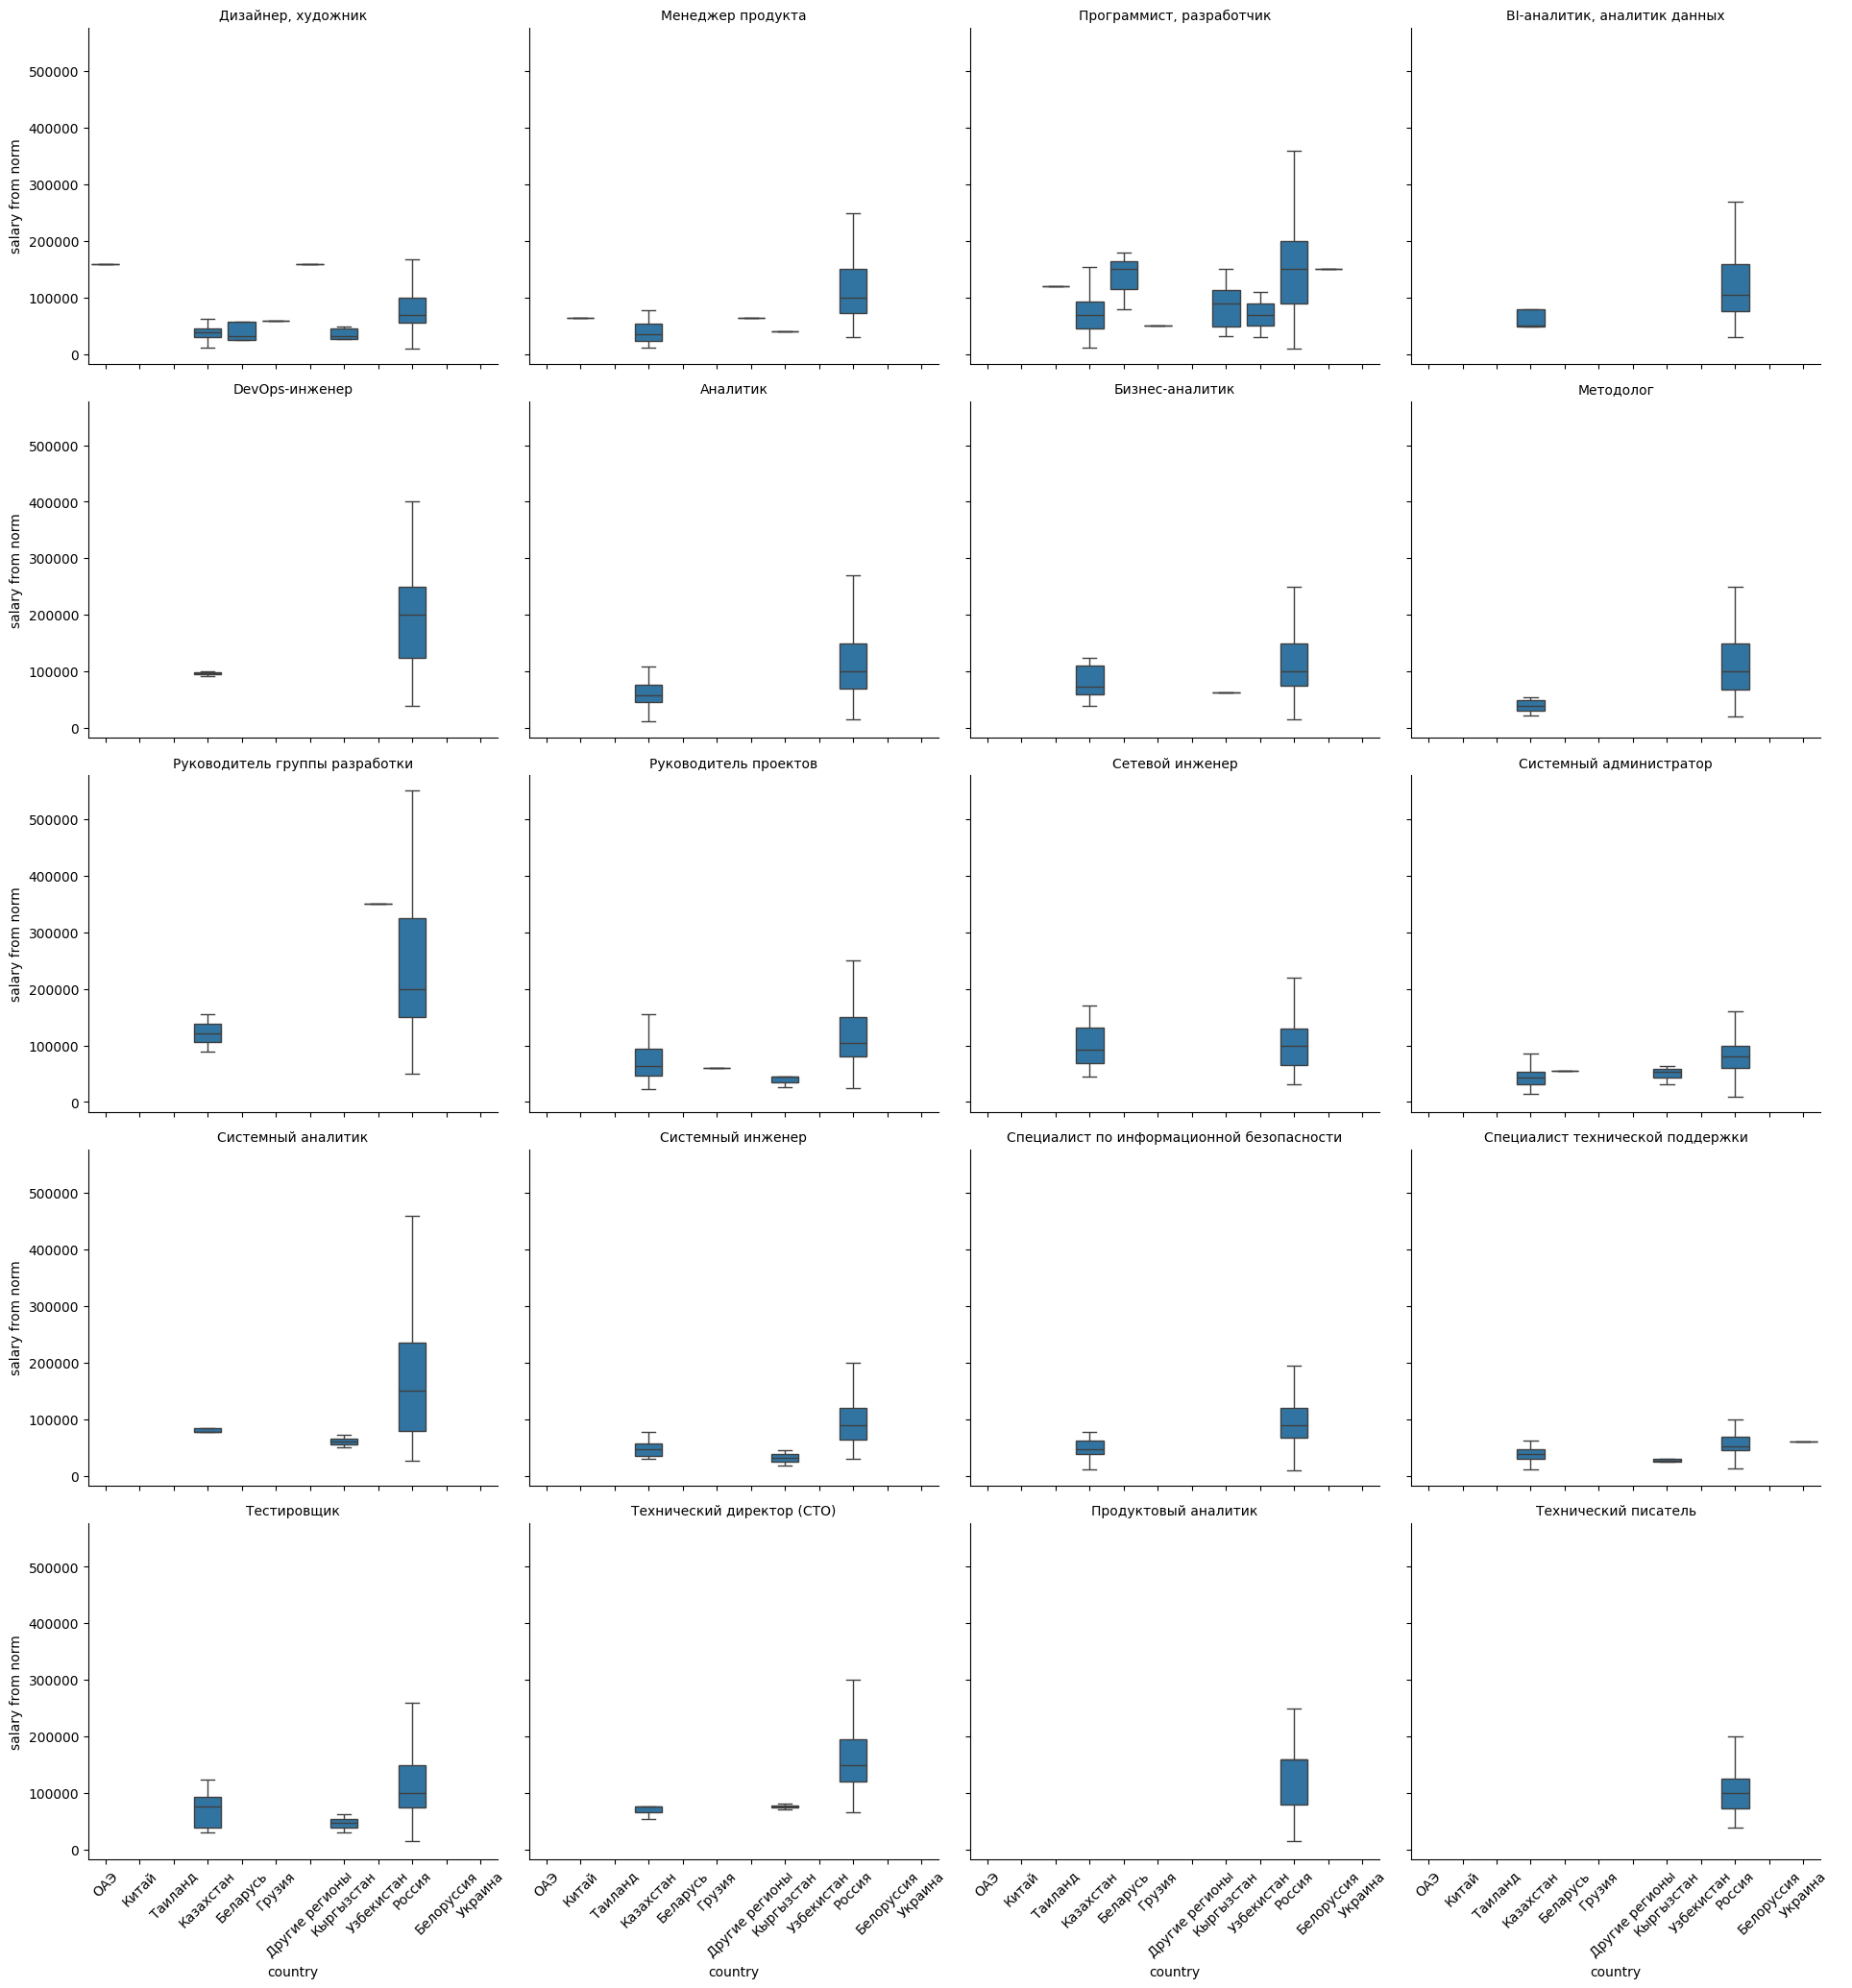

In [251]:

top_positions = df_train['position'].value_counts().head(20).index
df_top = df_train[df_train['position'].isin(top_positions)]

g = sns.catplot(
    data=df_top,
    x='country',
    y='salary from norm',
    col='position',
    col_wrap=4,
    kind='box',
    showfliers=False,
    height=4,
    aspect=1.2
)

g.set_titles(col_template="{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

In [259]:
# Фильтруем валидные строки
df_employment = df_copy.dropna(subset=['salary from norm', 'salary to norm', 'position', 'employment'])

# Группируем и считаем агрегации
grouped = df_employment.groupby(['position', 'employment'])[
    ['salary from norm', 'salary to norm']
].agg(['median', 'mean', 'count']).round(1)

# Сбросим индекс для сортировки
grouped_reset = grouped.reset_index()

# Сортируем внутри каждой позиции по median salary from
grouped_sorted = grouped_reset.sort_values(
    by=['position', ('salary from norm', 'median')],
    ascending=[True, True]
)

# Вернём multiindex обратно для удобства отображения
grouped_sorted = grouped_sorted.set_index(['position', 'employment'])

# Показываем полную таблицу
with pd.option_context('display.max_rows', None):
    display(grouped_sorted)


salary from norm  \
                                                                           median   
position                                     employment                             
BI-аналитик, аналитик данных                 Частичная занятость          42500.0   
                                             Проектная работа            100000.0   
                                             Полная занятость            110000.0   
DevOps-инженер                               Частичная занятость         100000.0   
                                             Полная занятость            200000.0   
                                             Проектная работа            285000.0   
Аналитик                                     Частичная занятость          15457.0   
                                             Полная занятость            100000.0   
                                             Проектная работа            165000.0   
Арт-директор, креативный директор            Частичная занятость          30915.0   
                                             Полная занятость            114100.5   
Бизнес-аналитик                              Проектная работа             20000.0   
                                             Частичная занятость          50000.0   
                                             Полная занятость            100000.0   
Гейм-дизайнер                                Частичная занятость          75000.0   
                                             Полная занятость             80000.0   
Дата-сайентист                               Полная занятость            200000.0   
Дизайнер, художник                           Частичная занятость          45000.0   
                                             Проектная работа             50000.0   
                                             Полная занятость             70000.0   
Директор по информационным технологиям (CIO) Полная занятость            200000.0   
                                             Проектная работа            250000.0   
Менеджер продукта                            Частичная занятость          50000.0   
                                             Полная занятость            100000.0   
Методолог                                    Частичная занятость          40000.0   
                                             Полная занятость            100000.0   
                                             Проектная работа            105457.5   
Программист, разработчик                     Частичная занятость          69558.0   
                                             Проектная работа             90000.0   
                                             Полная занятость            140000.0   
Продуктовый аналитик                         Частичная занятость          25000.0   
                                             Проектная работа             60000.0   
                                             Полная занятость            160000.0   
Руководитель группы разработки               Частичная занятость          90000.0   
                                             Полная занятость            200000.0   
Руководитель отдела аналитики                Полная занятость            125000.0   
Руководитель проектов                        Частичная занятость          45000.0   
                                             Проектная работа             80000.0   
                                             Полная занятость            100000.0   
Сетевой инженер                              Частичная занятость          45500.0   
                                             Полная занятость            100000.0   
Системный администратор                      Частичная занятость          43750.0   
                                             Полная занятость             80000.0   
                                             Проектная работа            120000.0   
Системный аналитик                           Частичная занятость      

In [260]:
# Фильтрация по нужным колонкам
df_schedule = df_copy.dropna(subset=['salary from norm', 'salary to norm', 'position', 'schedule'])

# Группировка и агрегация
grouped = df_schedule.groupby(['position', 'schedule'])[
    ['salary from norm', 'salary to norm']
].agg(['median', 'mean', 'count']).round(1)

# Сброс индекса для сортировки
grouped_reset = grouped.reset_index()

# Сортировка внутри каждой позиции по медиане зарплаты from
grouped_sorted = grouped_reset.sort_values(
    by=['position', ('salary from norm', 'median')],
    ascending=[True, True]
)

# Возвращаем MultiIndex для читаемости
grouped_sorted = grouped_sorted.set_index(['position', 'schedule'])

# Вывод
with pd.option_context('display.max_rows', None):
    display(grouped_sorted)

salary from norm  \
                                                                        median   
position                                     schedule                            
BI-аналитик, аналитик данных                 Сменный график            66900.0   
                                             Полный день              100000.0   
                                             Удаленная работа         120000.0   
DevOps-инженер                               Полный день              180000.0   
                                             Удаленная работа         200000.0   
Аналитик                                     Вахтовый метод            72000.0   
                                             Гибкий график             80000.0   
                                             Сменный график            83000.0   
                                             Полный день               90000.0   
                                             Удаленная работа         120000.0   
Арт-директор, креативный директор            Гибкий график             30915.0   
                                             Сменный график            93625.0   
                                             Полный день              100000.0   
                                             Удаленная работа         200000.0   
Бизнес-аналитик                              Гибкий график             61372.0   
                                             Полный день              100000.0   
                                             Удаленная работа         100000.0   
Гейм-дизайнер                                Полный день               70000.0   
                                             Удаленная работа         102500.0   
Дата-сайентист                               Полный день              110000.0   
                                             Удаленная работа         250000.0   
Дизайнер, художник                           Сменный график            53300.5   
                                             Гибкий график             54500.0   
                                             Полный день               70000.0   
                                             Удаленная работа          70000.0   
Директор по информационным технологиям (CIO) Полный день              200000.0   
                                             Удаленная работа         250000.0   
Менеджер продукта                            Сменный график            50000.0   
                                             Полный день              100000.0   
                                             Удаленная работа         100000.0   
                                             Гибкий график            113643.0   
Методолог                                    Гибкий график             70000.0   
                                             Удаленная работа          90000.0   
                                             Полный день              100000.0   
Программист, разработчик                     Вахтовый метод            27823.0   
                                             Сменный график            86000.0   
                                             Полный день              125000.0   
                                             Удаленная работа         150000.0   
                                             Гибкий график            157500.0   
Продуктовый аналитик                         Полный день              100000.0   
                                             Удаленная работа         160000.0   
Руководитель группы разработки               Полный день              200000.0   
                                             Удаленная работа         275000.0   
                                             Гибкий график            370000.0   
Руководитель отдела аналитики                Удаленная работа         110000.0   
                                             Полный день              133500.0   
Руководитель проектов                       

In [995]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11451 entries, 0 to 18691
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   position                11451 non-null  object 
 1   date                    11451 non-null  object 
 2   vacancy                 11451 non-null  object 
 3   company                 11451 non-null  object 
 4   city                    11451 non-null  object 
 5   experience              11451 non-null  object 
 6   employment              11451 non-null  object 
 7   schedule                11451 non-null  object 
 8   salary from             11451 non-null  float64
 9   salary to               11451 non-null  float64
 10  currency                11451 non-null  object 
 11  skills                  11451 non-null  object 
 12  country                 11451 non-null  object 
 13  industry                10800 non-null  object 
 14  skills_clean            11451 non-null  obj

### Level

In [1102]:

# Вспомогательная функция для выделения уровня
def extract_level(vacancy):
    # Каноны уровней
    levels = {
        r'(Стажёр|Стажер)': 'Стажёр',
        r'(Младший|Junior)': 'Младший/Junior',
        r'(Старший|Middle)': 'Старший/Middle',
        r'(Ведущий|Senior|head of)': 'Ведущий/Senior'
    }
    
    # Пробегаемся по всем уровням
    for pattern, level in levels.items():
        if re.search(pattern, vacancy, re.IGNORECASE):
            return level
            
    # Если ничего не найдено, возвращаем 'no'
    return 'no'


# Создаём новый столбец 'level'
df_copy['level'] = df_copy['vacancy_norm'].apply(lambda x: extract_level(x))

In [1103]:
df_copy['level'].value_counts()

level
no                9923
Ведущий/Senior     772
Старший/Middle     367
Младший/Junior     266
Стажёр             123
Name: count, dtype: int64

In [1134]:

def extract_level(vacancy):
    """Максимально оптимизированная версия"""
    if not isinstance(vacancy, str):
        return 'no'
    
    levels = {
        'chief': [
            r'\bchief\b',
            r'\bcto\b|\bcio\b|\bctio\b',
            #r'\bглавный\b',
            r'\bhead\s+of\b'
        ],
        'lead': [
            r'\btech\s*lead\b',
            r'\bteam\s*lead\b',
            r'\bteam\s*head\b',
            r'\bqa\s*lead\b',
            r'\blead\s+[a-z]+\b',  # Новый паттерн для Lead в начале
            r'\blead\b',  # Отдельное слово Lead
            r'\b[a-z]+\s+lead\b',  # Любое слово перед lead
            r'\bтехлид\b',
            r'\bруководитель\b',
            r'\bлид\b'
        ],
        
        'senior': [
            r'\bsenior\b',
            r'\bстарший\b',
            r'\bведущий\b'
        ],
        'middle': [
            r'\bmiddle\b',
            r'\bmid\b',
            r'\bсредний\b'
        ],
        'junior': [
            r'\bjunior\b',
            r'\bмладший\b'
        ],
        'trainee': [
            r'\bintern\b',
            r'\btrainee\b',
            r'\bстаж[ёе]р\b'
        ]
    }
    
    vacancy_lower = vacancy.lower()
    for level, patterns in levels.items():
        if any(re.search(p, vacancy_lower) for p in patterns):
            return level.capitalize()
    
    return 'no'

# Создаём новый столбец 'level'
df_copy['level'] = df_copy['vacancy_norm'].apply(lambda x: extract_level(x))

In [1152]:
def extract_level_2(vacancy):
    """Максимально оптимизированная версия"""
    if not isinstance(vacancy, str):
        return 'no'
    
    levels = {
        'chief': [
            r'\bchief\b',
            r'\bcto\b|\bcio\b|\bctio\b',
            #r'\bглавный\b',
            r'\bhead\s+of\b'
        ],
        'lead\senior': [
            r'\btech\s*lead\b',
            r'\bteam\s*lead\b',
            r'\bteam\s*head\b',
            r'\bqa\s*lead\b',
            r'\blead\s+[a-z]+\b',  # Новый паттерн для Lead в начале
            r'\blead\b',  # Отдельное слово Lead
            r'\b[a-z]+\s+lead\b',  # Любое слово перед lead
            r'\bтехлид\b',
            r'\bруководитель\b',
            r'\bлид\b',
            r'\bsenior\b',
            r'\bстарший\b',
            r'\bведущий\b'
        ],
        
        'middle': [
            r'\bmiddle\b',
            r'\bmid\b',
            r'\bсредний\b'
        ],
        'junior': [
            r'\bjunior\b',
            r'\bмладший\b'
        ],
        'trainee': [
            r'\bintern\b',
            r'\btrainee\b',
            r'\bстаж[ёе]р\b'
        ]
    }
    
    vacancy_lower = vacancy.lower()
    for level, patterns in levels.items():
        if any(re.search(p, vacancy_lower) for p in patterns):
            return level.capitalize()
    
    return 'no'

# Создаём новый столбец 'level'
df_copy['level'] = df_copy['vacancy_norm'].apply(lambda x: extract_level_2(x))

#### Changed

In [1153]:
df_copy['level'].value_counts()

level
no             9355
Lead\senior    1529
Junior          251
Middle          175
Trainee         128
Chief            13
Name: count, dtype: int64

In [ ]:


def plot_salary_from_distribution(df):
    """
    Визуализирует распределение зарплат 'salary from norm' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные (убираем выбросы и нулевые значения)
    filtered = df_copy[(df_copy['country'] == 'Россия') & 
                (df_copy['salary from norm'] > 0) & 
                 (df_copy['salary from norm'] < df_copy['salary from norm'].quantile(0.99)) &
                 (df_copy['level'] != 'no')]
    
    # Строим boxplot
    sns.violinplot(
        x='level', 
        y='salary from norm', 
        data=filtered,
        order=['Trainee', 'Junior', 'Middle', 'Lead\senior', 'Chief'],
        palette='viridis'
    )
    
    plt.title('Распределение зарплат "от" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "от" (нормированная)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary from norm'].describe()

def plot_salary_to_distribution(df):
    """
    Визуализирует распределение зарплат 'salary to norm' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные
    filtered = df_copy[(df_copy['country'] == 'Россия') &  (df_copy['salary to norm'] > 0) & 
                 (df_copy['salary to norm'] < df_copy['salary to norm'].quantile(0.99)) &
                 (df_copy['level'] != 'no')]
    
    # Строим violin plot для лучшего отображения распределения
    sns.violinplot(
        x='level', 
        y='salary to norm', 
        data=filtered,
        order=['Trainee', 'Junior', 'Middle', 'Lead\senior', 'Chief'],
        palette='magma',
        cut=0
    )
    
    plt.title('Распределение зарплат "до" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "до" (нормированная)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary to norm'].describe()

C:\Users\Андрей\AppData\Local\Temp\ipykernel_6032\100306831.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


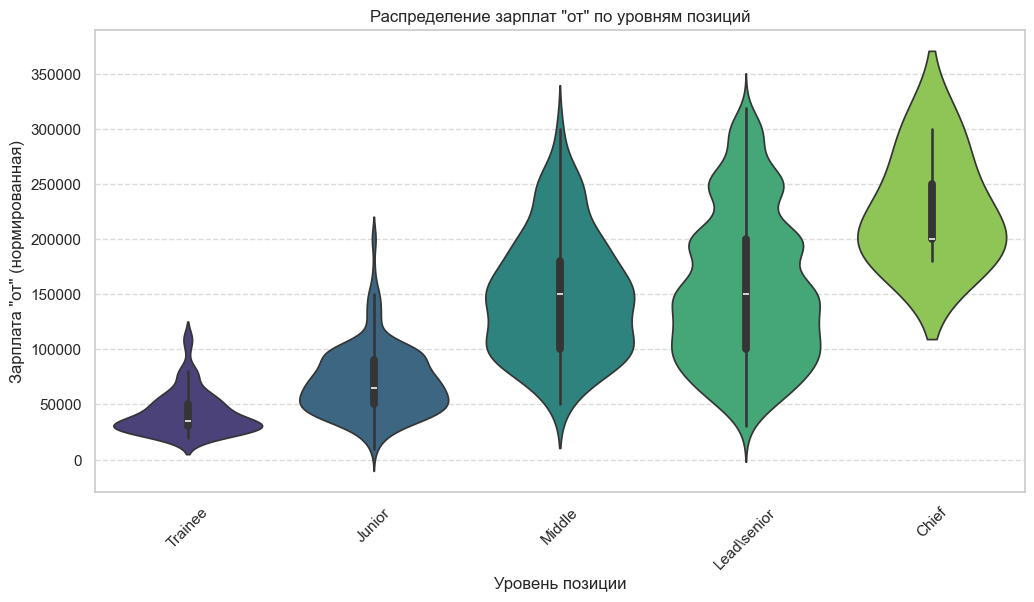

count           mean           std       min       25%  \
level                                                                  
Chief           5.0  226000.000000  48785.243671  180000.0  200000.0   
Junior        237.0   70502.869198  30251.409860   10000.0   50000.0   
Lead\senior  1283.0  153968.858924  66791.316210   30000.0  100000.0   
Middle        155.0  149050.967742  54176.204063   50000.0  100000.0   
Trainee       117.0   42348.991453  19593.413411   20000.0   30000.0   

                  50%       75%       max  
level                                      
Chief        200000.0  250000.0  300000.0  
Junior        65000.0   90000.0  200000.0  
Lead\senior  150000.0  200000.0  318456.0  
Middle       150000.0  180000.0  300000.0  
Trainee       35000.0   50000.0  110000.0

C:\Users\Андрей\AppData\Local\Temp\ipykernel_6032\100306831.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


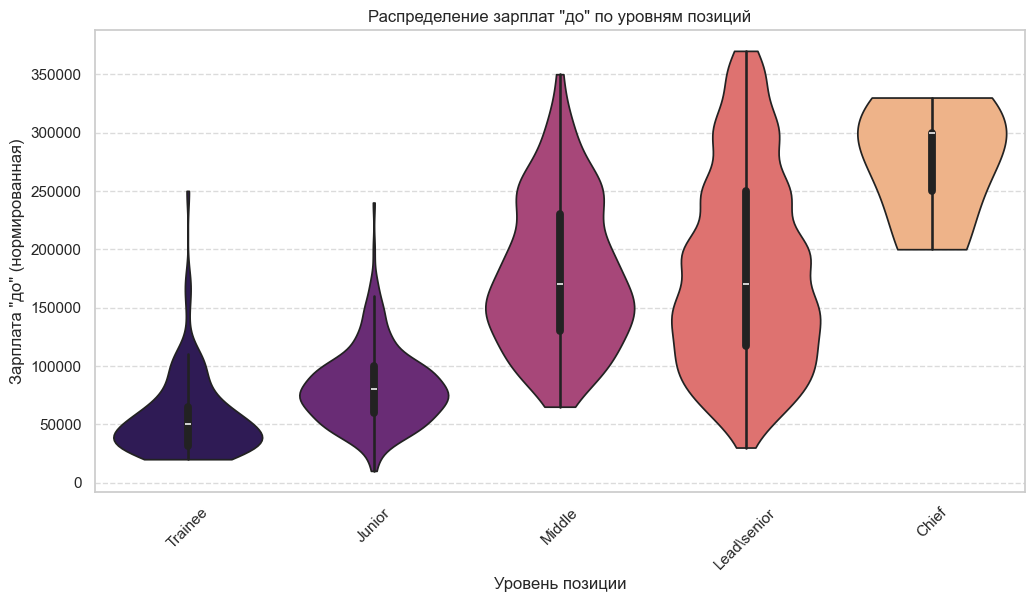

count           mean           std       min       25%  \
level                                                                  
Chief           5.0  276000.000000  51283.525620  200000.0  250000.0   
Junior        238.0   81545.714286  32450.104837   10000.0   60000.0   
Lead\senior  1301.0  180363.764796  82256.261425   30000.0  117000.0   
Middle        157.0  178540.764331  62489.727315   65000.0  130000.0   
Trainee       117.0   56460.102564  34902.549096   20000.0   31000.0   

                  50%       75%       max  
level                                      
Chief        300000.0  300000.0  330000.0  
Junior        80000.0  100000.0  240000.0  
Lead\senior  170000.0  250000.0  370000.0  
Middle       170000.0  230000.0  350000.0  
Trainee       50000.0   65000.0  250000.0

In [1157]:
# Для зарплат "от"
stats_from = plot_salary_from_distribution(df_copy)
display(stats_from)

# Для зарплат "до" 
stats_to = plot_salary_to_distribution(df_copy)
display(stats_to)

In [1146]:
df_copy[(df_copy['country'] == 'Россия') & (df_copy['level'] == 'Trainee') & (df_copy['salary to norm'] > 120000)]

position                      date  \
1750                  Аналитик  2025-06-04T12:48:04+0300   
1816                  Аналитик  2025-06-06T08:15:37+0300   
1845                  Аналитик  2025-06-04T19:57:46+0300   
6362  Программист, разработчик  2025-05-12T15:06:12+0300   

                              vacancy        company    city experience  \
1750               Стажер/Аналитик 1С         Гензис  Москва  Нет опыта   
1816               Стажер-Аналитик 1С         Гензис  Москва   1–3 года   
1845           Стажер-Аналитик 1С:ЗУП         Гензис  Москва   1–3 года   
6362  Стажер-программист ASP.NET (C#)  4А.Консалтинг  Москва   1–3 года   

            employment     schedule  salary from  salary to  ...  \
1750  Полная занятость  Полный день      60000.0   170000.0  ...   
1816  Полная занятость  Полный день      80000.0   170000.0  ...   
1845  Полная занятость  Полный день      80000.0   250000.0  ...   
6362  Полная занятость  Полный день      50000.0   150000.0  ...   

                                           skills_clean  \
1750  [1С: Предприятие 8, 1C: Бухгалтерия, 1С програ...   
1816  [1С: Предприятие 8, 1C: Бухгалтерия, 1С програ...   
1845  [1С: Предприятие 8, 1C: Бухгалтерия, Бухгалтер...   
6362     [Visual Studio C#, JavaScript, HTML5, C#, SQL]   

                                      skills_clean_norm salary from norm  \
1750  [1С: Зарплата и управление персоналом, SQL, ув...          60000.0   
1816  [1С: Зарплата и управление персоналом, SQL, ув...          80000.0   
1845  [1С: Зарплата и управление персоналом, SQL, ув...          80000.0   
6362     [C#, JavaScript, SQL, HTML5, Visual Studio C#]          50000.0   

     salary to norm         vacancy_clean   vacancy_final  \
1750       170000.0           аналитик 1с     аналитик 1с   
1816       170000.0           аналитик 1с     аналитик 1с   
1845       250000.0        аналитик 1сзуп  аналитик 1сзуп   
6362       150000.0  программист aspnet c           Other   

      vacancy_final_no_other                vacancy_norm    level  \
1750             аналитик 1с          Стажер/Аналитик 1С  Trainee   
1816             аналитик 1с          Стажер-аналитик 1С  Trainee   
1845          аналитик 1сзуп      Стажер-Аналитик 1С:ЗУП  Trainee   
6362                     NaN  Стажер-программист ASP.NET  Trainee   

                  vacancy_norm_1  
1750          Стажер/Аналитик 1С  
1816          Стажер-аналитик 1С  
1845      Стажер-Аналитик 1С:ЗУП  
6362  Стажер-программист ASP.NET  

[4 rows x 24 columns]

In [1081]:
df_copy['vacancy_norm'].value_counts()

vacancy_norm
Специалист технической поддержки    561
Системный администратор             530
Программист 1С                      447
Графический дизайнер                188
Системный аналитик                  119
                                   ... 
Стажер в отдел веб-разработки         1
Разработчик программных роботов       1
Стажер программист/аналитик 1С        1
Junior разработчик                    1
Технический писатель, технолог        1
Name: count, Length: 5165, dtype: int64

In [ ]:
# Поверхностная проработка 1С

def unify_1c_to_russian(text):
    if not isinstance(text, str):
        return text
    
    # Заменяем '1 С', '1 C' (с пробелом) на '1С'
    text = re.sub(r'\b1\s+[СсCc]\b', '1С', text, flags=re.IGNORECASE)

    # Заменяем '1с', '1c', '1С', '1C' (без пробела), но строго как отдельное слово
    text = re.sub(r'\b1[сcСC]\b', '1С', text, flags=re.IGNORECASE)

    return text
df_copy['vacancy_norm_1'] = df_copy['vacancy_norm'].apply(unify_1c_to_russian)

def canonicalize_position(text):
    
    if '1С' not in text:
        return text
    else:
        # Канонические профессии
        professions = ['Программист', 'Аналитик', 'Разработчик', 'Консультант', 'Специалист']
        
        # Уровень квалификации
        levels = ['Младший', 'Старший', 'Ведущий', 'Junior', 'Middle', 'Senior']
        
        canons = ['Программист 1С', 'Аналитик 1С', 'Разработчик 1С', 'Консультант 1С', 'Специалист 1С']
        
        # Проверяем наличие профессий
        for canon in  canons:
            if text == canon:
                return text
        found_profession = next((prof for prof in professions if prof.lower() in text.lower()), None)
            
        if found_profession is None:
            return text  # Ничего не делаем, если профессия не найдена
            
        # Проверяем уровень квалификации
        found_level = next((level for level in levels if level.lower() in text.lower()), '')
            
        # Формирование финального результата
        final_text = found_profession
        if found_level:
            final_text += ' ' + found_level + ' 1С'
        
        return final_text.strip()
    
    
df['vacancy_norm_1'] = df['vacancy_norm_1'].apply(canonicalize_position)



# Регулярное выражение для поиска '1с' или '1c' (русская и английская "с", без учёта регистра)
pattern = re.compile(r'1[сc]', re.IGNORECASE)

# Отфильтруем вакансии, где встречается '1с' или '1c'
vacancies_with_1c = df['vacancy_norm_1'].dropna().astype(str).loc[
    df['vacancy_norm_1'].astype(str).apply(lambda x: bool(pattern.search(x)))
]

# Посчитаем частоты
freq = Counter(vacancies_with_1c)

# Выведем результат, отсортированный по убыванию
for vac, count in freq.most_common():
    print(f"{vac}: {count}")
all_vacancy = df['vacancy_norm_1'].unique().tolist()
len(all_vacancy)


Программист 1С: 453
Аналитик 1С: 97
Разработчик 1С: 79
Программист Ведущий 1С: 69
Консультант 1С: 60
Аналитик Ведущий 1С: 33
Разработчик Ведущий 1С: 31
Специалист 1С: 14
Руководитель проектов 1С: 12
Консультант Ведущий 1С: 11
Программист Старший 1С: 10
Аналитик Старший 1С: 10
Программист Middle 1С: 9
Программист Младший 1С: 7
Администратор 1С: 6
Системный администратор 1С: 5
Программист Junior 1С: 5
Аналитик Младший 1С: 4
Специалист Ведущий 1С: 4
Архитектор 1С: 3
Инженер 1С: 3
Разработчик Старший 1С: 3
Руководитель службы поддержки 1С ЗУП: 3
Тестировщик 1С: 3
Методист 1С: 2
Стажер в отдел внедрения 1С: 2
Оператор 1С: 2
Менеджер проектов 1С: 2
Руководитель проекта 1С: 2
Системный администратор со знанием 1С: 2
Эксперт по автоматизации разработки 1С: 1
Консультант Junior 1С: 1
Специалист Младший 1С: 1
Консультант Middle 1С: 1
Аналитик Middle 1С: 1
Методолог 1С по оперативному контуру: 1
Администратор 1С КА ERP: 1
Эксперт по технологическим вопросам 1С: 1
Оператор WMS, 1С: 1
Администратор

C:\Users\Андрей\AppData\Local\Temp\ipykernel_6032\2050569479.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vacancy_norm_1'] = df['vacancy_norm_1'].apply(canonicalize_position)


4781

In [1083]:
df_copy['vacancy_norm_1'].value_counts(ascending= True)

vacancy_norm_1
Смм-менеджер                                                     1
Технический специалист по работе с проектными организациями      1
Инженер в сектор руководства заказами                            1
Руководитель проекта b2b                                         1
Специалист по работе с проектными организациями                  1
                                                              ... 
Системный аналитик                                             119
Графический дизайнер                                           188
Программист 1С                                                 453
Системный администратор                                        530
Специалист технической поддержки                               561
Name: count, Length: 5160, dtype: int64

In [1149]:
def normalize_case_in_vacancies(df, text_column='vacancy_norm_llm_check_1'):
    """
    Нормализует регистр в названиях вакансий, используя существующие правильные написания
    
    Параметры:
        df - DataFrame с данными
        text_column - название столбца с текстом вакансий
        
    Возвращает:
        Модифицированный DataFrame с исправленным регистром
    """
    # Создаем словарь правильных написаний (вакансия в нижнем регистре -> правильный вариант)
    case_dict = {}
    
    # Собираем все уникальные названия
    unique_vacancies = df[text_column].dropna().unique()
    
    # Заполняем словарь: ключ - lowercase, значение - правильное написание
    for vacancy in unique_vacancies:
        if isinstance(vacancy, str):
            lower_vacancy = vacancy.lower()
            # Если уже есть такой вариант, выбираем то написание, где больше заглавных букв
            if lower_vacancy in case_dict:
                current = case_dict[lower_vacancy]
                # Выбираем вариант с большим числом заглавных букв
                if sum(1 for c in vacancy if c.isupper()) > sum(1 for c in current if c.isupper()):
                    case_dict[lower_vacancy] = vacancy
            else:
                case_dict[lower_vacancy] = vacancy
    
    # Функция для замены регистра
    def correct_case(text):
        if not isinstance(text, str):
            return text
        lower_text = text.lower()
        return case_dict.get(lower_text, text)
    
    # Применяем исправления
    df[text_column] = df[text_column].apply(correct_case)
    
    return df

In [1150]:
df_copy = normalize_case_in_vacancies(df_copy, 'vacancy_norm_1')

In [1151]:
df_copy['vacancy_norm_1'].value_counts(ascending= True)

vacancy_norm_1
Смм-менеджер                                                     1
Технический специалист по работе с проектными организациями      1
Инженер в сектор руководства заказами                            1
Руководитель проекта b2b                                         1
Специалист по работе с проектными организациями                  1
                                                              ... 
Системный аналитик                                             119
Графический дизайнер                                           188
Программист 1С                                                 453
Системный администратор                                        530
Специалист технической поддержки                               561
Name: count, Length: 5158, dtype: int64

#### Save to CSV

In [1158]:
df_copy.to_csv('df_copy_temp.csv')

In [432]:
df_copy['employment'].value_counts()

employment
Полная занятость       11181
Частичная занятость      213
Проектная работа          57
Name: count, dtype: int64

In [434]:
df_copy['schedule'].value_counts()

schedule
Полный день         7621
Удаленная работа    3264
Сменный график       364
Гибкий график        163
Вахтовый метод        39
Name: count, dtype: int64

In [482]:
df_copy['country'].value_counts()

country
Россия            10796
Казахстан           565
Кыргызстан           53
Беларусь             13
Другие регионы        7
Таиланд               3
Грузия                3
Узбекистан            3
США                   2
ОАЭ                   2
Китай                 1
Сербия                1
Белоруссия            1
Украина               1
Name: count, dtype: int64

In [ ]:
df_train_result = df_copy[(df_copy['country'] == 'Россия') ][['salary from norm', 'salary to norm', 'position', 'experience', 'skills_clean_norm', 'schedule','employment', 'vacancy_norm']] 

In [977]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10796 entries, 1317 to 18691
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary from norm   10320 non-null  float64
 1   salary to norm     10335 non-null  float64
 2   position           10796 non-null  object 
 3   experience         10796 non-null  object 
 4   skills_clean_norm  10796 non-null  object 
 5   schedule           10796 non-null  object 
 6   employment         10796 non-null  object 
 7   vacancy_norm       10796 non-null  object 
dtypes: float64(2), object(6)
memory usage: 759.1+ KB


In [998]:
df_train_result

salary from  salary to                      position experience  \
1317      120000.0   120000.0  BI-аналитик, аналитик данных   1–3 года   
1318      120000.0   120000.0  BI-аналитик, аналитик данных   1–3 года   
1319      120000.0   120000.0  BI-аналитик, аналитик данных   1–3 года   
1321      120000.0   150000.0  BI-аналитик, аналитик данных   1–3 года   
1322       35000.0    35000.0  BI-аналитик, аналитик данных  Нет опыта   
...            ...        ...                           ...        ...   
18687     150000.0   150000.0          Технический писатель   1–3 года   
18688      40000.0    40000.0          Технический писатель   1–3 года   
18689     100000.0   100000.0          Технический писатель   1–3 года   
18690     100000.0   100000.0          Технический писатель   1–3 года   
18691     150000.0   150000.0          Технический писатель    3–6 лет   

                                                  skills          schedule  \
1317   [Confluence, JavaScript, JQL, Atlassian Jira, ...  Удаленная работа   
1318   [Confluence, JavaScript, JQL, Atlassian Jira, ...  Удаленная работа   
1319   [Confluence, JavaScript, JQL, Atlassian Jira, ...  Удаленная работа   
1321                                      [1с, MS Excel]  Удаленная работа   
1322                              [SQL, Tableau, Python]       Полный день   
...                                                  ...               ...   
18687                      [Грамотная речь, Грамотность]       Полный день   
18688                         [Техническая документация]       Полный день   
18689  [Проектная документация, Разработка проектной ...       Полный день   
18690                    [Работа в команде, Грамотность]       Полный день   
18691  [Разработка технической документации, Сбор тре...       Полный день   

             employment                         vacancy_norm  
1317   Полная занятость             Администратор приложений  
1318   Полная занятость             Администратор приложений  
1319   Полная занятость             Администратор приложений  
1321   Полная занятость                   Аналитик данных BI  
1322   Полная занятость                      Стажер-аналитик  
...                 ...                                  ...  
18687  Полная занятость         Младший технический писатель  
18688  Полная занятость                 Технический писатель  
18689  Полная занятость  Инженер по технической документации  
18690  Полная занятость                 Технический писатель  
18691  Полная занятость       Технический писатель, технолог  

[9394 rows x 8 columns]

In [ ]:
# Удаляем пустые - бывшие выбросы
df_train_result = df_train_result.dropna(subset=['salary from norm', 'salary to norm'], how='any')

In [979]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10167 entries, 1317 to 18691
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary from norm   10167 non-null  float64
 1   salary to norm     10167 non-null  float64
 2   position           10167 non-null  object 
 3   experience         10167 non-null  object 
 4   skills_clean_norm  10167 non-null  object 
 5   schedule           10167 non-null  object 
 6   employment         10167 non-null  object 
 7   vacancy_norm       10167 non-null  object 
dtypes: float64(2), object(6)
memory usage: 714.9+ KB


In [981]:
df_train_result.rename(columns={'skills_clean_norm': 'skills'}, inplace=True)

In [ ]:


# Для статистики
position_skill_stats = []

# Копия для результата
df_skills_filtered = df_train_result.copy()

# Проходим по всем позициям
for pos in df_skills_filtered['position'].unique():
    mask = df_skills_filtered['position'] == pos
    skills_lists = df_skills_filtered.loc[mask, 'skills']

    # Объединяем все скиллы в один список
    all_skills = [skill for sublist in skills_lists for skill in sublist]
    
    # Считаем топ-25 по частоте
    skill_counts = Counter(all_skills)
    top_25_skills = set([skill for skill, _ in skill_counts.most_common(50)])

    # До и после
    original_unique = set(all_skills)
    remaining_skills = set()
    
    # Применяем фильтр
    df_skills_filtered.loc[mask, 'skills'] = skills_lists.apply(
        lambda skill_list: [s for s in skill_list if s in top_25_skills]
    )
    
    # Пересчитываем оставшиеся после фильтра
    filtered_skills = df_skills_filtered.loc[mask, 'skills']
    remaining_skills.update([skill for sublist in filtered_skills for skill in sublist])

    # Добавим статистику
    position_skill_stats.append({
        'position': pos,
        'skills_total_before': len(original_unique),
        'skills_after_top30': len(remaining_skills),
        'skills_removed': len(original_unique - remaining_skills)
    })

# Итоговая таблица
df_skill_stats = pd.DataFrame(position_skill_stats).sort_values(by='skills_removed', ascending=False)

# Показать
display(df_skill_stats)

position  skills_total_before  \
11                      Программист, разработчик                 2163   
21              Специалист технической поддержки                 1266   
15                         Руководитель проектов                 1248   
7                             Дизайнер, художник                 1011   
2                                       Аналитик                  937   
17                       Системный администратор                  880   
9                              Менеджер продукта                  660   
20     Специалист по информационной безопасности                  620   
19                             Системный инженер                  441   
22                                   Тестировщик                  402   
4                                Бизнес-аналитик                  384   
16                               Сетевой инженер                  379   
10                                     Методолог                  369   
13                Руководитель группы разработки                  338   
18                            Системный аналитик                  338   
23                    Технический директор (CTO)                  294   
0                   BI-аналитик, аналитик данных                  270   
24                          Технический писатель                  225   
1                                 DevOps-инженер                  223   
12                          Продуктовый аналитик                  180   
3              Арт-директор, креативный директор                  142   
8   Директор по информационным технологиям (CIO)                  130   
14                 Руководитель отдела аналитики                  121   
6                                 Дата-сайентист                  112   
5                                  Гейм-дизайнер                   71   

    skills_after_top30  skills_removed  
11                  50            2113  
21                  50            1216  
15                  50            1198  
7                   50             961  
2                   50             887  
17                  50             830  
9                   50             610  
20                  50             570  
19                  50             391  
22                  50             352  
4                   50             334  
16                  50             329  
10                  50             319  
13                  50             288  
18                  50             288  
23                  50             244  
0                   50             220  
24                  50             175  
1                   50             173  
12                  50             130  
3                   50              92  
8                   50              80  
14                  50              71  
6                   50              62  
5                   50              21

In [ ]:

# Для статистики
position_skill_stats = []

# Копия для результата
#df_skills_filtered = df_train_result.copy()

# Убедимся, что 'skills' — это списки (на случай, если сериализовано как строки)
df_skills_filtered['skills'] = df_skills_filtered['skills'].apply(
    lambda x: literal_eval(x) if isinstance(x, str) else x
)

# Проходим по всем позициям
for pos in df_skills_filtered['position'].unique():
    mask = df_skills_filtered['position'] == pos
    skills_lists = df_skills_filtered.loc[mask, 'skills']

    # Объединяем все скиллы в один список
    all_skills = [skill for sublist in skills_lists for skill in sublist]

    # Считаем топ-100 по частоте
    skill_counts = Counter(all_skills)
    top_25_skills = set([skill for skill, _ in skill_counts.most_common(50)])

    # До фильтрации
    original_unique = set(all_skills)

    # Применяем фильтр
    df_skills_filtered.loc[mask, 'skills'] = skills_lists.apply(
        lambda skill_list: [s for s in skill_list if s in top_25_skills]
    )

    # Пересчитываем оставшиеся после фильтра
    filtered_skills = df_skills_filtered.loc[mask, 'skills']
    remaining_skills = set(skill for sublist in filtered_skills for skill in sublist)

    # Добавим статистику
    position_skill_stats.append({
        'position': pos,
        'skills_total_before': len(original_unique),
        'skills_after_top100': len(remaining_skills),
        'skills_removed': len(original_unique - remaining_skills),
        'remaining_skills_list': sorted(remaining_skills)  # <- список оставшихся скиллов
    })

# Итоговая таблица
df_skill_stats = pd.DataFrame(position_skill_stats).sort_values(by='skills_removed', ascending=False)

# Показать
with pd.option_context('display.max_rows', 150, 'display.max_colwidth', None):
    display(df_skill_stats)


position  skills_total_before  \
0                   BI-аналитик, аналитик данных                   50   
13                Руководитель группы разработки                   50   
23                    Технический директор (CTO)                   50   
22                                   Тестировщик                   50   
21              Специалист технической поддержки                   50   
20     Специалист по информационной безопасности                   50   
19                             Системный инженер                   50   
18                            Системный аналитик                   50   
17                       Системный администратор                   50   
16                               Сетевой инженер                   50   
15                         Руководитель проектов                   50   
14                 Руководитель отдела аналитики                   50   
12                          Продуктовый аналитик                   50   
1                                 DevOps-инженер                   50   
11                      Программист, разработчик                   50   
10                                     Методолог                   50   
9                              Менеджер продукта                   50   
8   Директор по информационным технологиям (CIO)                   50   
7                             Дизайнер, художник                   50   
6                                 Дата-сайентист                   50   
5                                  Гейм-дизайнер                   50   
4                                Бизнес-аналитик                   50   
3              Арт-директор, креативный директор                   50   
2                                       Аналитик                   50   
24                          Технический писатель                   50   

    skills_after_top100  skills_removed  \
0                    20              30   
13                   20              30   
23                   20              30   
22                   20              30   
21                   20              30   
20                   20              30   
19                   20              30   
18                   20              30   
17                   20              30   
16                   20              30   
15                   20              30   
14                   20              30   
12                   20              30   
1                    20              30   
11                   20              30   
10                   20              30   
9                    20              30   
8                    20              30   
7                    20              30   
6                    20              30   
5                    20              30   
4                    20              30   
3                    20              30   
2                    20              30   
24                   20              30   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        remaining_skills_list  
0                                                                                                                                                                                                                                                               [1с, MS Excel, MS SQL, PostgreSQL, Power BI, Power Query, Python, SQL, Анализ данных, Аналитическое мышление, Бизнес-анализ, Визуализация данн

In [983]:
df_skills_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10167 entries, 1317 to 18691
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   salary from norm  10167 non-null  float64
 1   salary to norm    10167 non-null  float64
 2   position          10167 non-null  object 
 3   experience        10167 non-null  object 
 4   skills            10167 non-null  object 
 5   schedule          10167 non-null  object 
 6   employment        10167 non-null  object 
 7   vacancy_norm      10167 non-null  object 
dtypes: float64(2), object(6)
memory usage: 714.9+ KB


In [984]:
# Отфильтруем строки с пустыми списками после удаления топ-25
empty_skills_df = df_skills_filtered[df_skills_filtered['skills'].apply(lambda x: len(x) == 0)]

# Посмотрим, сколько таких строк и какие позиции
print(f"Всего строк с пустыми списками скиллов: {len(empty_skills_df)}")

# Группировка по position — где чаще всего остались пустые
empty_counts = empty_skills_df['position'].value_counts()

# Показать
display(empty_counts)

Всего строк с пустыми списками скиллов: 773


position
Программист, разработчик                        250
Специалист технической поддержки                100
Системный администратор                          70
Руководитель проектов                            64
Дизайнер, художник                               55
Аналитик                                         45
Специалист по информационной безопасности        40
Менеджер продукта                                25
Методолог                                        20
Сетевой инженер                                  20
Системный аналитик                               13
Системный инженер                                13
Бизнес-аналитик                                  11
Тестировщик                                      10
Руководитель группы разработки                    8
Технический директор (CTO)                        8
BI-аналитик, аналитик данных                      6
Руководитель отдела аналитики                     4
Продуктовый аналитик                              2
Dev

In [985]:
df_skills_filtered = df_skills_filtered[df_skills_filtered['skills'].apply(lambda x: len(x) > 0)]

In [735]:


# Добавим колонку с количеством скиллов в каждой вакансии
df_skills_filtered['skills_count'] = df_skills_filtered['skills'].apply(len)

# Группировка по позиции и количеству скиллов
skills_distribution = (
    df_skills_filtered
    .groupby(['position', 'skills_count'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=range(1, 21), fill_value=0)  # Убедимся, что есть столбцы от 1 до 20
)

skills_distribution

skills_count                                   1    2    3    4    5    6   \
position                                                                     
BI-аналитик, аналитик данных                    6   13   23   16   14   11   
DevOps-инженер                                  4    4    5    6   11   10   
Аналитик                                       82  110  107   98   86   59   
Арт-директор, креативный директор               1    1    3    1    3    6   
Бизнес-аналитик                                15   28   24   19   22   14   
Гейм-дизайнер                                   0    0    1    0    1    2   
Дата-сайентист                                  2    5    0    2    2    2   
Дизайнер, художник                             85  103  120  128  145   95   
Директор по информационным технологиям (CIO)    0    1    0    1    4    2   
Менеджер продукта                              31   40   36   35   36   22   
Методолог                                       9   12   30   23   10    5   
Программист, разработчик                      255  355  372  395  276  228   
Продуктовый аналитик                            2    5   13   26    3    2   
Руководитель группы разработки                  6   19   17   13   14    6   
Руководитель отдела аналитики                   1    2    1    1    2    3   
Руководитель проектов                          83  114  113  117  108   88   
Сетевой инженер                                14   24   17   21    9   16   
Системный администратор                        70   80  100  115  150   84   
Системный аналитик                             19   14   25   18   22   13   
Системный инженер                              17   22   18   25   13   14   
Специалист по информационной безопасности      73   66   62   51   45   15   
Специалист технической поддержки              138  393  200  256  208  128   
Тестировщик                                    20   18   33   14   24   11   
Технический директор (CTO)                      6    8   13   10    6    7   
Технический писатель                            8    9   13   14   12    5   

skills_count                                   7    8   9   10  11  12  13  \
position                                                                     
BI-аналитик, аналитик данных                   15    7   5   3   1   2   1   
DevOps-инженер                                  8    9  18   5   2   1   5   
Аналитик                                       29   28  34  15   6   7   2   
Арт-директор, креативный директор               2    4   1   2   0   1   1   
Бизнес-аналитик                                15    5   9  10   3   5   0   
Гейм-дизайнер                                   3    0   1   0   0   0   0   
Дата-сайентист                                  0    3   3   2   2  13   1   
Дизайнер, художник                             60   50  35  26  24  11  18   
Директор по информационным технологиям (CIO)    2    3   1   1   8   0   0   
Менеджер продукта                              19   10  10   5   1  13   0   
Методолог                                       3    4   0   2   1   0   0   
Программист, разработчик                      203  105  86  29  33  16  14   
Продуктовый аналитик                            5    0   1   1   1   0   6   
Руководитель группы разработки                  4    3   9   1   3   1   0   
Руководитель отдела аналитики                   1    2   3   1   0   1   1   
Руководитель проектов                          50   30  21  19  13  10   3   
Сетевой инженер                                 7   12   2   6   2   5   0   
Системный администратор                        77   52  41  41  15  23  15   
Системный аналитик                             11   10  10   9  14   6   3   
Системный инженер                               5    7   8   6   3   3   1   
Специалист по информационной безопасности      21   10  14   7   2   0   1   
Специалист технической поддержки              154   71  50  32  42   6  11   
Тестировщик          

In [736]:
# Фильтруем вакансии с ровно одним скиллом
one_skill_df = df_skills_filtered[df_skills_filtered['skills'].apply(len) == 1].copy()

# Добавим колонку с единственным скиллом
one_skill_df['single_skill'] = one_skill_df['skills'].apply(lambda x: x[0] if x else None)

# Группируем по позиции и берём по 5 примеров
examples_per_position = (
    one_skill_df
    .groupby('position')
    .apply(lambda x: x[['single_skill']].head(5))
    .reset_index(level=0)
)

# Показываем результат
with pd.option_context('display.max_rows', 150):
    display(examples_per_position)

C:\Users\Андрей\AppData\Local\Temp\ipykernel_6032\711497813.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  one_skill_df


position  \
1333                BI-аналитик, аналитик данных   
1374                BI-аналитик, аналитик данных   
1422                BI-аналитик, аналитик данных   
1448                BI-аналитик, аналитик данных   
1482                BI-аналитик, аналитик данных   
1564                              DevOps-инженер   
1590                              DevOps-инженер   
1644                              DevOps-инженер   
1686                              DevOps-инженер   
1723                                    Аналитик   
1724                                    Аналитик   
1749                                    Аналитик   
1767                                    Аналитик   
1768                                    Аналитик   
2852           Арт-директор, креативный директор   
2948                             Бизнес-аналитик   
2982                             Бизнес-аналитик   
2983                             Бизнес-аналитик   
2984                             Бизнес-аналитик   
2988                             Бизнес-аналитик   
3249                              Дата-сайентист   
3271                              Дата-сайентист   
3292                          Дизайнер, художник   
3299                          Дизайнер, художник   
3318                          Дизайнер, художник   
3348                          Дизайнер, художник   
3370                          Дизайнер, художник   
4978                           Менеджер продукта   
4982                           Менеджер продукта   
5036                           Менеджер продукта   
5045                           Менеджер продукта   
5057                           Менеджер продукта   
5463                                   Методолог   
5473                                   Методолог   
5477                                   Методолог   
5485                                   Методолог   
5531                                   Методолог   
5681                    Программист, разработчик   
5701                    Программист, разработчик   
5723                    Программист, разработчик   
5727                    Программист, разработчик   
5744                    Программист, разработчик   
9448                        Продуктовый аналитик   
9453                        Продуктовый аналитик   
9608              Руководитель группы разработки   
9628              Руководитель группы разработки   
9635              Руководитель группы разработки   
9642              Руководитель группы разработки   
9657              Руководитель группы разработки   
9703               Руководитель отдела аналитики   
9712                       Руководитель проектов   
9780                       Руководитель проектов   
9790                       Руководитель проектов   
9808                       Руководитель проектов   
9819                       Руководитель проектов   
11243                            Сетевой инженер   
11251                            Сетевой инженер   
11264                            Сетевой инженер   
11273                            Сетевой инженер   
11282                            Сетевой инженер   
11500                    Системный администратор   
11519                    Системный администратор   
11617                    Системный администратор   
11618                    Системный администратор   
11623                    Системный администратор   
13330                         Системный аналитик   
13350                         Системный аналитик   
13352                         Системный аналитик   
13423                         Системный аналитик   
13467                         Системный аналитик   
13611                          Системный инженер   
13645                          Системный инженер   
13661                          Системный инженер   
13670                          Системный инженер   
13714                          Системный инженер   
13927  Специалист по информационной безопасности   
13929  Специалист по информационной 

In [765]:
# Фильтруем строки с нужной позицией и ровно одним скиллом
subset = df_skills_filtered[
    (df_skills_filtered['position'] == 'Программист, разработчик') &
    (df_skills_filtered['skills'].apply(len) == 1)
]

# Отображаем 10 полных строк
subset.head(10)

salary from norm  salary to norm                  position experience  \
5653          200000.0        280000.0  Программист, разработчик   1–3 года   
5658          200000.0        280000.0  Программист, разработчик   1–3 года   
5661          200000.0        280000.0  Программист, разработчик   1–3 года   
5681          120000.0        180000.0  Программист, разработчик   1–3 года   
5711          245700.0        245700.0  Программист, разработчик    3–6 лет   
5723          180000.0        200000.0  Программист, разработчик    3–6 лет   
5744          180000.0        180000.0  Программист, разработчик   1–3 года   
5766           25000.0         35000.0  Программист, разработчик  Нет опыта   
5771          170000.0        200000.0  Программист, разработчик   1–3 года   
5783          200000.0        200000.0  Программист, разработчик    3–6 лет   

                          skills          schedule           employment  
5653       [1с программирование]  Удаленная работа     Полная занятость  
5658       [1с программирование]  Удаленная работа     Полная занятость  
5661       [1с программирование]       Полный день     Полная занятость  
5681  [Создание конфигурации 1С]       Полный день     Полная занятость  
5711                       [SQL]       Полный день     Полная занятость  
5723       [1с программирование]       Полный день     Полная занятость  
5744       [1с программирование]       Полный день     Полная занятость  
5766                       [Git]       Полный день  Частичная занятость  
5771                     [Linux]       Полный день     Полная занятость  
5783                       [SQL]       Полный день     Полная занятость

In [986]:
df_skills_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9394 entries, 1317 to 18691
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   salary from norm  9394 non-null   float64
 1   salary to norm    9394 non-null   float64
 2   position          9394 non-null   object 
 3   experience        9394 non-null   object 
 4   skills            9394 non-null   object 
 5   schedule          9394 non-null   object 
 6   employment        9394 non-null   object 
 7   vacancy_norm      9394 non-null   object 
dtypes: float64(2), object(6)
memory usage: 660.5+ KB


In [ ]:
df_skills_filtered = df_skills_filtered.drop('skills_count', axis = 1)

In [987]:
df_train_result = df_skills_filtered.copy()

In [988]:
df_train_result.rename(columns={
    'salary from norm': 'salary from',
    'salary to norm': 'salary to'
}, inplace=True)

In [989]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9394 entries, 1317 to 18691
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   salary from   9394 non-null   float64
 1   salary to     9394 non-null   float64
 2   position      9394 non-null   object 
 3   experience    9394 non-null   object 
 4   skills        9394 non-null   object 
 5   schedule      9394 non-null   object 
 6   employment    9394 non-null   object 
 7   vacancy_norm  9394 non-null   object 
dtypes: float64(2), object(6)
memory usage: 660.5+ KB


In [ ]:
#не трогаем дубли , они помогут модели распознавать дисперсию лучше
'''
# Создадим вспомогательную колонку, где skills — строка через запятую
df_train_result['skills_str'] = df_train_result['skills'].apply(lambda x: ','.join(sorted(x)) if isinstance(x, list) else '')

# Удалим дубликаты по нужным колонкам, включая новую строковую колонку
df_train_result = df_train_result.drop_duplicates(subset=['position', 'experience', 'schedule','employment','vacancy_final', 'skills_str'])

# Удалим вспомогательную колонку
df_train_result = df_train_result.drop(columns=['skills_str'])

'''

In [991]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9394 entries, 1317 to 18691
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   salary from   9394 non-null   float64
 1   salary to     9394 non-null   float64
 2   position      9394 non-null   object 
 3   experience    9394 non-null   object 
 4   skills        9394 non-null   object 
 5   schedule      9394 non-null   object 
 6   employment    9394 non-null   object 
 7   vacancy_norm  9394 non-null   object 
dtypes: float64(2), object(6)
memory usage: 660.5+ KB


In [992]:
top_n = 50

def filter_top_vacancies(group, n=top_n):
    # Считаем частоты вакансий внутри позиции
    vac_counts = group['vacancy_norm'].value_counts()
    top_vacancies = vac_counts.head(n).index.tolist()
    # Оставляем только строки с вакансиями из топ-N
    return group[group['vacancy_norm'].isin(top_vacancies)]

df_filtered = df_train_result.groupby('position').apply(filter_top_vacancies).reset_index(drop=True)

print(f"Исходное число строк: {len(df_train_result)}")
print(f"Число строк после фильтрации: {len(df_filtered)}")

Исходное число строк: 9394
Число строк после фильтрации: 5714


C:\Users\Андрей\AppData\Local\Temp\ipykernel_6032\3254153459.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_train_result.groupby('position').apply(filter_top_vacancies).reset_index(drop=True)


In [993]:
df_train_vac_result = df_filtered

In [994]:
df_train_vac_result.to_csv('df_train_vac_result.csv')

In [915]:
df_train_result.to_csv('df_train_result.csv')

In [990]:
all_skills = flatten_skills(df_train_result['skills'])
test_unique_skills_count = len(set(all_skills))
display(test_unique_skills_count)

609

### 3. Modeling


#### 3.1. Modeling salary from

In [808]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Целевая переменная
target_col = 'salary from'

# Категориальные признаки
cat_features = ['position', 'experience','schedule','employment'] # ,'vacancy_final' 
multilabel_feature = 'skills'

# Выделяем X и y
X = df_train_result[cat_features + [multilabel_feature]]
y = df_train_result[target_col]

# Обработка признаков
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
mlb = MultiLabelBinarizer()

# Кодируем
X_ohe = ohe.fit_transform(X[cat_features])
X_mlb = mlb.fit_transform(X['skills'])

# Объединяем
X_final = np.hstack([X_ohe, X_mlb])

In [809]:
# Отдельно зафиксировать стратифицированные индексы по position

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X_final, df_train_result['position']):
    X_train, X_test = X_final[train_idx], X_final[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

ridge_model = Ridge(random_state=42)

# Сетка параметров
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10,  50],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'fit_intercept': [True, False],
}

grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    cv=3,  # 3-фолд кросс-валидация
    scoring='neg_mean_absolute_error',  # или 'r2', 'neg_mean_squared_error'
    n_jobs=-1,
    verbose=1
)

# Обучение
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)
print("MAE на cross-val:", -grid_search.best_score_)

# Лучшая модель
best_ridge = grid_search.best_estimator_

#ridge_model.fit(X_train, y_train)
y_pred_ridge = best_ridge.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge — MAE: {mae_ridge:.2f}, R²: {r2_ridge:.2f}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Лучшие параметры: {'alpha': 0.5, 'fit_intercept': False, 'solver': 'lsqr'}
MAE на cross-val: 30921.414833507395
Ridge — MAE: 30130.35, R²: 0.57


In [688]:
ridge_model = Ridge(random_state=42, alpha = 1, fit_intercept = False, solver = 'lsqr' )

ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge — MAE: {mae_ridge:.2f}, R²: {r2_ridge:.2f}")

Ridge — MAE: 32383.65, R²: 0.56


In [810]:
from sklearn.ensemble import RandomForestRegressor
rf_model_1 = RandomForestRegressor(n_estimators=200, max_depth=40, random_state=42, n_jobs=-1, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2)
rf_model_1.fit(X_train, y_train)
y_pred_rf = rf_model_1.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest — MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

Random Forest — MAE: 28295.06, R²: 0.62


In [694]:
# Базовая модель
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Сетка гиперпараметров
param_grid = {
    'n_estimators': [100, 200],            # Кол-во деревьев
    'max_depth': [ 12, 15, 20, 30],             # Глубина деревьев
    'min_samples_split': [2, 5],           # Мин. выборка для сплита
    'min_samples_leaf': [1, 2, 3],            # Мин. выборка в листе
    'max_features': ['sqrt', 'log2'],      # Кол-во фичей при сплите
}

# GridSearch
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-фолд кросс-валидация
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Обучение
grid_search_rf.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search_rf.best_params_)
print("MAE на кросс-валидации:", -grid_search_rf.best_score_)

# Лучшая модель
best_rf = grid_search_rf.best_estimator_

# Тестирование на отложенной выборке
y_pred_rf = best_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest (лучшее) — MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Лучшие параметры: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE на кросс-валидации: 29654.52332698936
Random Forest (лучшее) — MAE: 28748.46, R²: 0.62


#### 3.2. Modeling salary to

In [811]:
# Целевая переменная
target_col = 'salary to'

# Категориальные признаки
cat_features = ['position', 'experience','schedule','employment'] # ,'vacancy_final' 
multilabel_feature = 'skills'

# Выделяем X и y
X = df_train_result[cat_features + [multilabel_feature]]
y = df_train_result[target_col]

# Обработка признаков
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
mlb = MultiLabelBinarizer()

# Кодируем
X_ohe = ohe.fit_transform(X[cat_features])
X_mlb = mlb.fit_transform(X['skills'])

# Объединяем
X_final = np.hstack([X_ohe, X_mlb])

In [812]:
# Отдельно зафиксировать стратифицированные индексы по position

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X_final, df_train_result['position']):
    X_train, X_test = X_final[train_idx], X_final[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [813]:
from sklearn.ensemble import RandomForestRegressor
rf_model_2 = RandomForestRegressor(n_estimators=200, max_depth=40, random_state=42, n_jobs=-1, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2)
rf_model_2.fit(X_train, y_train)
y_pred_rf = rf_model_2.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest — MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

Random Forest — MAE: 32703.34, R²: 0.61


#### 4. Model adaptation

In [805]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from collections import defaultdict

# Словарь для хранения топ-20 skills по каждой позиции
top_skills_per_position = defaultdict(list)

# Основные признаки
cat_features = ['experience', 'schedule', 'employment']  # без position, т.к. будет по одной
skill_feature = 'skills'

# Перебор по каждой позиции
for pos in df_train_result['position'].unique():
    df_pos = df_train_result[df_train_result['position'] == pos].copy()
    
    # Пропускаем слишком маленькие выборки
    #if len(df_pos) < 100:
    #    continue

    # Признаки и цель
    X = df_pos[cat_features + [skill_feature]]
    y = df_pos['salary to']  # или 'salary from'

    # Кодирование
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    mlb = MultiLabelBinarizer()
    
    X_ohe = ohe.fit_transform(X[cat_features])
    X_mlb = mlb.fit_transform(X[skill_feature])
    
    X_final = np.hstack([X_ohe, X_mlb])
    
    # Разделим (можно без test, тут важно только фичи)
    X_train, _, y_train, _ = train_test_split(X_final, y, test_size=0.2, random_state=42)

    # Обучение модели
    rf = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
    rf.fit(X_train, y_train)

    # Список всех признаков
    feature_names = list(ohe.get_feature_names_out(cat_features)) + list(mlb.classes_)

    # Важности
    importances = rf.feature_importances_
    feat_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    # Фильтруем только скиллы
    skill_df = feat_df[feat_df['feature'].isin(mlb.classes_)]
    top_skills = skill_df.sort_values(by='importance', ascending=False).head(20)

    # Сохраняем
    top_skills_per_position[pos] = top_skills['feature'].tolist()

In [806]:
for pos, skills in top_skills_per_position.items():
    print(f"\n📌 Position: {pos}")
    print(skills)


📌 Position: BI-аналитик, аналитик данных
['Power BI', 'MS SQL', 'Python', 'MS Excel', 'SQL', 'Power Query', 'Бизнес-анализ', 'Работа с базами данных', 'Формирование аналитической отчетности', 'Анализ требований', 'Аналитическое мышление', 'ETL', '1с', 'Анализ данных', 'Исследовательский анализ данных', 'PostgreSQL', 'Визуализация данных', 'Интерпретация данных', 'Математическая статистика', 'MS PowerPoint']

📌 Position: DevOps-инженер
['Ansible', 'Kubernetes', 'Python', 'Docker', 'Администрирование серверов Linux', 'Nginx', 'Grafana', 'MS SQL Server', 'Prometheus', 'Terraform', 'Jenkins', 'Zabbix', 'DevOps', 'Helm', 'Gitlab', 'CI/CD', 'PostgreSQL', 'Linux', 'ELK', 'Bash']

📌 Position: Аналитик
['ERP-системы на базе 1С', 'Аналитическое мышление', 'Постановка задач разработчикам', 'MS Excel', '1C: ERP', 'Автоматизация бизнес-процессов', '1С: Предприятие 8', 'Работа с большим объемом информации', '1С: Бухгалтерия', 'Разработка технических заданий', '1с', '1С: Зарплата и управление персон

In [ ]:
# сохраняем 20 навыков по каждой позиции
import json

with open('top_skills_by_position.json', 'w', encoding='utf-8') as f:
    json.dump(top_skills_per_position, f, ensure_ascii=False, indent=2)

In [815]:
import joblib

# Сохраняем обученные модели
joblib.dump(rf_model_1, 'joblib/rf_model_from.joblib')
joblib.dump(rf_model_2, 'joblib/rf_model_to.joblib')

# Сохраняем энкодеры
joblib.dump(ohe, 'joblib/ohe_encoder.joblib')
joblib.dump(mlb, 'joblib/mlb_encoder.joblib')

['joblib/mlb_encoder.joblib']

In [817]:
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("joblib:", joblib.__version__)

numpy: 1.23.5
pandas: 2.3.0+4.g1dfc98e16a
joblib: 1.2.0


In [539]:
df_copy['vacancy'].value_counts()

vacancy
Специалист технической поддержки                                          491
Системный администратор                                                   448
Программист 1С                                                            351
Графический дизайнер                                                      156
Специалист поддержки                                                      103
                                                                         ... 
Разработчик программных роботов (Robotic process automation developer)      1
Стажер в отдел веб-разработки                                               1
Программист 1С (стажер, начальный уровень)                                  1
Программист-стажер 1С (Омск)                                                1
Технический писатель, технолог                                              1
Name: count, Length: 6477, dtype: int64

In [537]:
df_copy['vacancy'].value_counts().head(100)

vacancy
Специалист технической поддержки       491
Системный администратор                448
Программист 1С                         351
Графический дизайнер                   156
Специалист поддержки                   103
                                      ... 
Дизайнер одежды                          8
Аналитик 1С (ученик)                     8
Арт-директор                             8
Тестировщик                              8
Руководитель проектного направления      8
Name: count, Length: 100, dtype: int64

In [540]:
# Функция для очистки названия
def normalize_vacancy(text):
    text = str(text).lower()
    text = re.sub(r'\b(junior|middle|senior|удалённо|удаленно|remote|full-time|part-time|team lead|intern|стажер|ведущий|главный)\b', '', text)
    text = re.sub(r'[^a-zа-яё0-9\s+]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_copy['vacancy_clean'] = df_copy['vacancy'].apply(normalize_vacancy)

In [541]:
df_copy['vacancy_clean'].value_counts()

vacancy_clean
специалист технической поддержки                501
системный администратор                         491
программист 1с                                  434
графический дизайнер                            165
специалист поддержки                            103
                                               ... 
ученик программиста 1с                            1
программистстажёр 1с                              1
frontendразработчик saas it integration team      1
младший mauixamarin разработчик                   1
технический писатель технолог                     1
Name: count, Length: 5913, dtype: int64

In [593]:
def top_n_vacancies_by_position(df, n=20, min_count=5, min_position_size=50):
    df['vacancy_final'] = 'Other'
    
    for pos in df['position'].unique():
        mask = df['position'] == pos
        pos_size = mask.sum()

        # Если данных по позиции мало — оставляем всё как есть
        if pos_size < min_position_size:
            df.loc[mask, 'vacancy_final'] = df.loc[mask, 'vacancy_clean']
        else:
            vac_counts = Counter(df.loc[mask, 'vacancy_clean'])
            top_vacs = [name for name, count in vac_counts.most_common(n) if count >= min_count]
            df.loc[mask & df['vacancy_clean'].isin(top_vacs), 'vacancy_final'] = df.loc[mask, 'vacancy_clean']
    
    return df

# Применяем функцию
df_copy = top_n_vacancies_by_position(df_copy, n=200, min_count=1, min_position_size=30)

In [594]:
df_copy['vacancy_final'].value_counts()

vacancy_final
Other                                           3348
специалист технической поддержки                 501
системный администратор                          490
программист 1с                                   433
графический дизайнер                             164
                                                ... 
менеджер по развитию бизнеса в категории ибп       1
помощник менеджера проекта сложные задачи          1
product manager b2c                                1
эксперт по пресейл сае                             1
технический писатель технолог                      1
Name: count, Length: 2700, dtype: int64

In [595]:
# Фильтруем только те, которые не "Other"
vacancy_counts = df_copy['vacancy_final'].value_counts()
filtered = vacancy_counts[vacancy_counts.index != 'Other']

# Считаем, сколько из них имеют количество < 5
rare_count = (filtered < 2).sum()

print(f"Уникальных значений 'vacancy_final' (не 'Other') с числом вакансий < 5: {rare_count}")

Уникальных значений 'vacancy_final' (не 'Other') с числом вакансий < 5: 1831


In [617]:
df_copy['vacancy_final_no_other'] = df_copy['vacancy_final'].where(df_copy['vacancy_final'] != 'Other', np.nan)

In [596]:
vacancy_counts.head(50)

vacancy_final
Other                                                     3348
специалист технической поддержки                           501
системный администратор                                    490
программист 1с                                             433
графический дизайнер                                       164
специалист поддержки                                       103
разработчик 1с                                             101
системный аналитик                                          94
инженер технической поддержки                               92
инженерпрограммист                                          75
бизнесаналитик                                              68
дизайнер                                                    67
аналитик 1с                                                 67
специалист по информационной безопасности                   67
менеджер проектов                                           59
руководитель проектов                    